In [1486]:
from typing import List, Tuple, Optional, Mapping
import pandas as pd
import numpy as np
from collections import defaultdict
import statsmodels.api as sm
import matplotlib.pyplot as plt

import os
sys.path.append(os.path.relpath("../performance_evaluation/"))
from performance_utils import performance_for_df, NAV_df_plot
from predictors import *

%matplotlib inline

In [1487]:
class IndicesSelector():
    def __init__(self):
        pass

    def select(self, df: Optional[pd.DataFrame] = None) -> List[str]:
        price_df = pd.read_csv('../data/total_ret_idx_df.csv')
        return price_df['ETF_Ticker'].unique()

In [1488]:
class PairsSelector():
    def __init__(self):
        pass

    def select(self, df: Optional[pd.DataFrame] = None) -> List[List[str]]:
        training_df = pd.read_csv('../data/TrainingSet.csv')
        pairs = [[p.split("_")[0], p.split("_")[1]] for p in training_df["Ticker_Pair"].unique()]
        return pairs

In [1489]:
class SignalGenerator():
    def __init__(self):
        pass

    def pair_sig_to_asset_sig(self, price_df: pd.DataFrame, signal_df: pd.DataFrame, cost=100.0) -> pd.DataFrame:
        assets = price_df.columns
        strategy_asset = [[0] * len(assets)]

        def process_signal(x):
            if not x['pair']:
                strategy_asset.append([0] * len(assets))
                return
            buy_symbol = x['pair'].split('_')[0]
            sell_symbol = x['pair'].split('_')[1]
            buy_px = price_df.loc[x.name][buy_symbol]
            buy_qty = cost / buy_px
            sell_px = price_df.loc[x.name][sell_symbol]
            sell_qty = cost / sell_px
            if x['side'] == True:
                strategy_asset[-1][assets.get_loc(buy_symbol)] += buy_qty
                strategy_asset[-1][assets.get_loc(sell_symbol)] -= sell_qty 
                strategy_asset.append([0] * len(assets))
                strategy_asset[-1][assets.get_loc(buy_symbol)] -= buy_qty 
                strategy_asset[-1][assets.get_loc(sell_symbol)] += sell_qty 
            elif x['side'] == False:
                strategy_asset[-1][assets.get_loc(buy_symbol)] -= buy_qty 
                strategy_asset[-1][assets.get_loc(sell_symbol)] += sell_qty 
                strategy_asset.append([0] * len(assets))
                strategy_asset[-1][assets.get_loc(buy_symbol)] += buy_qty 
                strategy_asset[-1][assets.get_loc(sell_symbol)] -= sell_qty 
            else:
                strategy_asset.append([0] * len(assets))

        signal_df.iloc[:-1].apply(process_signal, axis=1) 
        return pd.DataFrame(strategy_asset, columns=assets, index=signal_df.index)


    def generate(self, pairs: List[str], price_df: pd.DataFrame, \
                 predict_df: pd.DataFrame, params: Optional[Mapping] = None)\
                 -> Tuple[pd.DataFrame, pd.DataFrame]:
        pass

In [1490]:
class PercentileCurrent(SignalGenerator):
    def __init__(self):
        pass

    def generate(self, pairs: List[str], price_df: pd.DataFrame, \
                 predict_df: pd.DataFrame, params: Optional[Mapping] = None)\
                 -> Tuple[pd.DataFrame, pd.DataFrame]:
        price_pivot_df = price_df.pivot_table("Total Return", ["Date"], columns="ETF_Ticker")
        price_pivot_df.index =pd.to_datetime(price_pivot_df.index)
        if params is None:
            params = {
                'holding_period': 20,
                'distribution_period': 60,
                'training_period': 2769,
                'cost': 100.,
                'periodic': False
            }
        holding_period = params["holding_period"]
        distribution_period = params["distribution_period"]
        training_period = params["training_period"]
        cost = params["cost"]
        periodic = params["periodic"]

        if not periodic:

            training_df = price_pivot_df.iloc[:training_period]
            
            ols_coeffs = {}
            for pair in pairs:
                df = training_df[[pair[0],pair[1]]].dropna()
                X = df[pair[0]]
                y = df[pair[1]]
                X = sm.add_constant(X)

                model = sm.OLS(y, X)
                results = model.fit()
                ols_coeffs[(pair[0], pair[1])] = results.params.iloc[0], results.params.iloc[1]
        
            signal_df = pd.DataFrame()
            for pair in pairs:
                col = '_'.join(pair)
                const_coeff, beta = ols_coeffs[(pair[0], pair[1])]
                signal_df[col] = price_pivot_df[pair[0]] - (price_pivot_df[pair[1]] * beta + const_coeff)
            signal_df = signal_df.rolling(distribution_period).apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1]) - 0.5
            signal_df = signal_df.iloc[::holding_period, :]
        else:
            signal_raw = defaultdict(list)
            for i in range(0, len(price_pivot_df), holding_period):
                if i < distribution_period or i < training_period:
                    for pair in pairs:
                        col = '_'.join(pair)
                        signal_raw[col].append(None)
                    continue
                for pair in pairs:
                    col = '_'.join(pair)
                    df = price_pivot_df.iloc[i - training_period:i][[pair[0],pair[1]]].dropna()
                    X = df[pair[0]]
                    y = df[pair[1]]
                    if len(y) < distribution_period * 0.3:
                        signal_raw[col].append(None)
                        continue
                    X = sm.add_constant(X)
                    model = sm.OLS(y, X)
                    results = model.fit()
                
                    const_coeff, beta = results.params.iloc[0], results.params.iloc[1]
                    spread = price_pivot_df.iloc[i-distribution_period+1:i+1][pair[0]] - (price_pivot_df.iloc[i-distribution_period+1:i+1][pair[1]] * beta + const_coeff)
                    signal_raw[col].append(spread.rank(pct=True).iloc[-1] - 0.5)
            signal_df = pd.DataFrame(signal_raw, index=price_pivot_df.iloc[::holding_period, :].index)

        signal_df['pair'] = np.abs(signal_df).idxmax(axis=1)
        signal_df['pair'].fillna(value='', inplace=True)
        signal_df['side'] = signal_df.apply(lambda x: x[x["pair"]] < 0 if x["pair"] else None, axis=1)
        pair_sig = self.pair_sig_to_asset_sig(price_pivot_df, signal_df, cost)
        asset_sig = signal_df[['pair', 'side']]
        return (pair_sig, asset_sig)
    

In [1491]:
class MostSpreadReturnPredict(SignalGenerator):
    def __init__(self):
        pass

    def generate(self, pairs: List[str], price_df: pd.DataFrame, \
                 predict_df: pd.DataFrame, params: Optional[Mapping] = None)\
                 -> Tuple[pd.DataFrame, pd.DataFrame]:

        price_pivot_df = price_df.pivot_table("Total Return", ["Date"], columns="ETF_Ticker")
        if params is None:
            params = {
                'holding_period': 1,
                'cost': 100.
            }
        cost = params["cost"]
        holding_period = params["holding_period"]
        signal_df = pd.DataFrame()
        predict_df = predict_df.reset_index()
        signal_df = predict_df.iloc[predict_df.groupby('Date')['pred_spread'].agg(lambda x: np.abs(x).idxmax())]
        signal_df.set_index("Date", inplace=True)
        signal_df.index = pd.to_datetime(signal_df.index)
        signal_df = signal_df.iloc[::holding_period, :]
        signal_df['side'] = signal_df['pred_spread'] > 0
        return self.pair_sig_to_asset_sig(price_pivot_df, signal_df, cost), signal_df[['pair', 'side']]

In [1492]:
class PairTradingPipeline():
    """
    @param price_df DataFrame with symbol columns and price values
    @param training_ratio ratio of the subset of the price_df to be used to select paris
    """
    def __init__(self, price_df: pd.DataFrame, training_ratio: float=0.5):
        self.test_date = '2017-01-01'
        self.price_df = price_df.copy()
        training_idx = int(len(price_df) * training_ratio)
        self.index_selection_df = self.price_df[:training_idx]
        self.pair_selection_df = self.price_df[training_idx:]
        self.selected_indices = None
        self.indicies_selector = IndicesSelector()
        self.pairs_selector = PairsSelector()
        self.selected_pairs = None
        self.predictors = {
            'linear': LinearPredictor(),
            'elastic': ElasticNetPredictor(),
            'XGB': XGBPredictor(),
            'lstm': LSTMPredictor()
        }
        self.predict_result = defaultdict(dict)
        self.signal_generator = {
            'percentile_current': PercentileCurrent(),
            'most_spread_rtn': MostSpreadReturnPredict()
        }
        self.signal_result = defaultdict(dict)

    def select_indicies(self) -> List[str]:
        self.selected_indices = self.indicies_selector.select(self.index_selection_df)
        return self.selected_indices

    def select_pairs(self) -> List[List[str]]:
        if self.selected_indices is None:
            self.select_indicies()
        # self.selected_pairs = self.pairs_selector.select(self.index_selection_df[[self.selected_indices]])
        self.selected_pairs = self.pairs_selector.select()
        return self.selected_pairs 

    def predict(self, predictor: str, pair: List[str], params: Optional[Mapping] = None, periodic: Optional[bool] = False):
        period = params['pred_period'] if params and params['pred_period'] else 'D'
        if periodic:
            # self.predict_result[predictor] = self.predictors[predictor].periodic_train_predict(self.pair_selection_df[pair])
            self.predict_result[period][predictor+'_periodic'] = \
                self.predictors[predictor].periodic_train_predict(params=params)
            return self.predict_result[period][predictor+'_periodic']
        else:
            # self.predictors[predictor].train(self.pair_selection_df)
            # self.predict_result[predictor] = self.predictors[predictor].predict(self.pair_selection_df[pair])
            self.predict_result[period][predictor] = \
                self.predictors[predictor].predict(params=params)
        return self.predict_result[period][predictor]
    
    def create_signal(self, signalGenerator: str, predict_df: pd.DataFrame, params: Optional[Mapping] = None):
        if self.selected_pairs is None:
            self.select_pairs()
        return self.signal_generator[signalGenerator].generate(self.selected_pairs, self.price_df, predict_df, params)
    
    def generate_portfolio(self, trade_df: pd.DataFrame, price_df: pd.DataFrame):
        
        etf_pos = (trade_df.reindex(price_df.index).fillna(0).cumsum() * price_df.fillna(0)).sum(axis = 1)
        port_df = pd.DataFrame(etf_pos, columns=['etf_pos'])
        port_df['cash_pos'] = (-trade_df * price_df).sum(axis = 1).cumsum()
        port_df['total_pos'] = etf_pos + port_df['cash_pos']
        return port_df

    def calc_port_return(self, port_df: pd.DataFrame, trade_df: pd.DataFrame, cost=100.):
        etf_ret = port_df[['etf_pos']].copy()
        etf_ret['base'] = etf_ret['etf_pos'].shift()
        per_period_ret = (port_df['cash_pos'] - port_df['cash_pos'].shift()).loc[trade_df.index]
        etf_ret['etf_pos'].loc[trade_df.index] = per_period_ret
        per_period_ret /= cost
        etf_ret += cost
        return (etf_ret['etf_pos'] / etf_ret['base'] - 1), per_period_ret

    def show_port_results(self, model_name, pair_trade_df, trade_df, price_df):

        plot_df = pair_trade_df.pivot_table(values='side', columns='pair', index=pair_trade_df.index)
        plot_df[plot_df == 0] = -1
        plot_df.plot(style='.', figsize=(9, 3), title=model_name + ' Pair Traded', \
                     ylabel='Side (buy: 1, sell: -1)', xlabel='Pair')
        plt.show()
        
        port_df = pipeline.generate_portfolio(trade_df, price_df)
        port_df.plot(figsize=(9, 3), title=model_name + ' Porfolio Value')
        plt.show()

        daily_ret_df, per_period_ret_df = pipeline.calc_port_return(port_df, trade_df)
        daily_ret_df.plot(figsize=(9, 3), title=model_name + ' Daily Return')
        plt.show()

        per_period_ret_df.plot(figsize=(9, 3), title=model_name + ' Per Trading Period Return')
        plt.show()

        return port_df, daily_ret_df, per_period_ret_df

    def run(self, model_name: str, periodic: Optional[bool] = False, params: Optional[Mapping] = None, 
            currentMode: Optional[bool] = False):
        period = params['pred_period'] if params and params['pred_period'] else 'D'
        if not currentMode:
            pred_df = self.predict(model_name, pairs, periodic=periodic, params=params)
            trade_df, pair_trade_df = self.create_signal('most_spread_rtn', pred_df, params)
        else:
            trade_df, pair_trade_df = self.create_signal(model_name, None, params)
        price_pivot_df = self.price_df.pivot_table("Total Return", ["Date"], columns="ETF_Ticker")
        price_pivot_df.index = pd.to_datetime(price_pivot_df.index)
        in_port_df, in_daily_ret_df, in_per_period_ret_df = self.show_port_results(model_name + " in-sample", \
            pair_trade_df.loc[:self.test_date], trade_df.loc[:self.test_date], price_pivot_df.loc[:self.test_date])
        out_port_df, out_daily_ret_df, out_per_period_ret_df = self.show_port_results(model_name + " out-sample", \
            pair_trade_df.loc[self.test_date:], trade_df.loc[self.test_date:], price_pivot_df.loc[self.test_date:])
        self.signal_result[period][model_name+('_periodic' if periodic else '')] = \
            [[in_port_df, in_daily_ret_df, in_per_period_ret_df], [out_port_df, out_daily_ret_df, out_per_period_ret_df]]
    


In [1493]:
price_df = pd.read_csv('../data/total_ret_idx_df.csv')
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_pivot_df = price_df.pivot_table("Total Return", ["Date"], columns="ETF_Ticker")
price_pivot_df.index =pd.to_datetime(price_pivot_df.index)

training_df = pd.read_csv('../data/TrainingSet.csv')
training_df

pipeline = PairTradingPipeline(price_df)
pairs = pipeline.select_pairs()

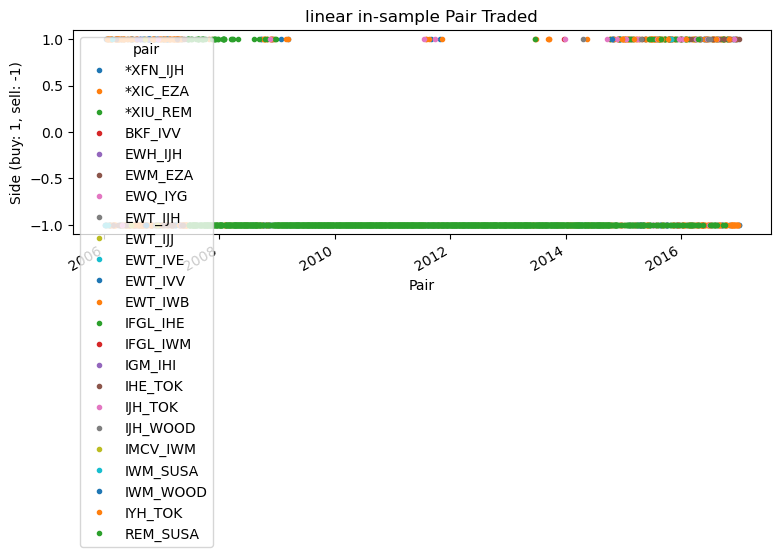

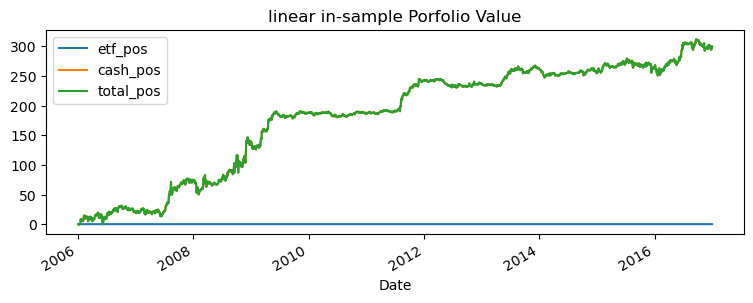

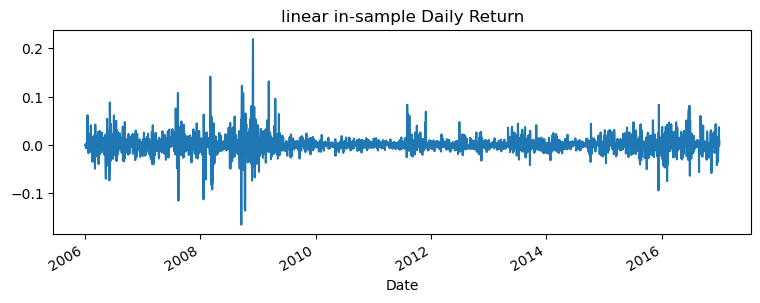

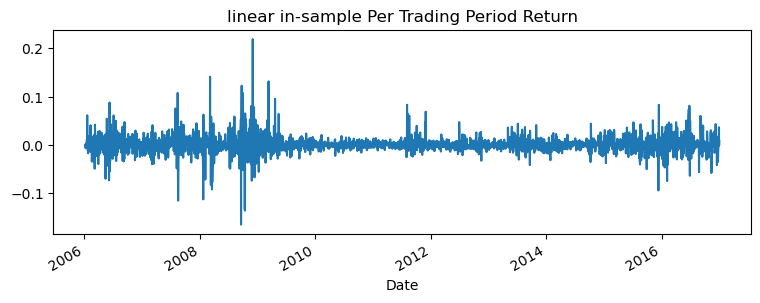

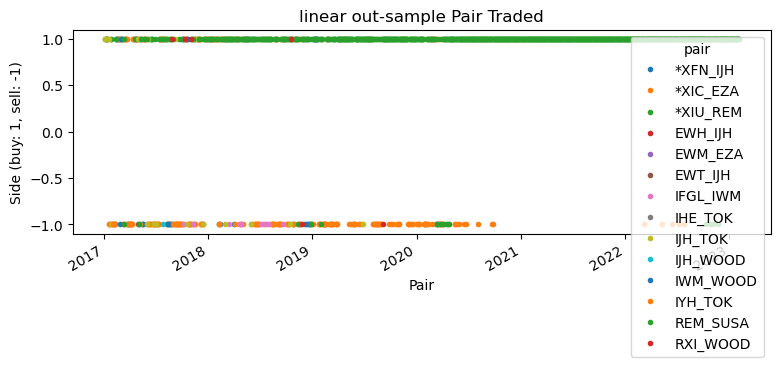

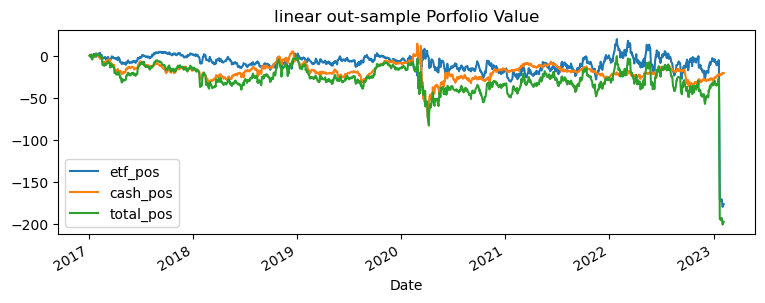

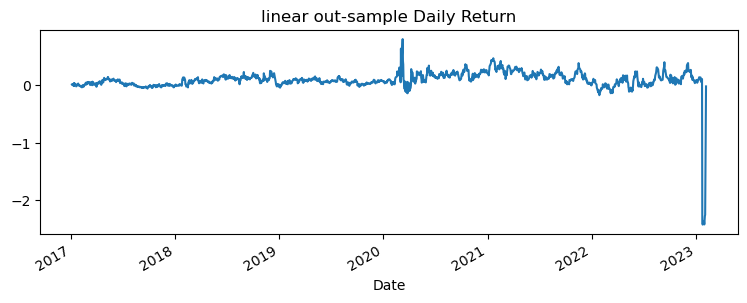

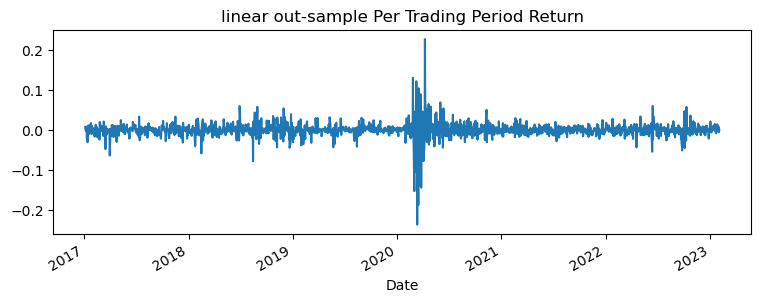

In [1494]:
pipeline.run('linear', params = {
                'pred_period': 'D',
                'cost' : 100,
                'holding_period': 1,
            })

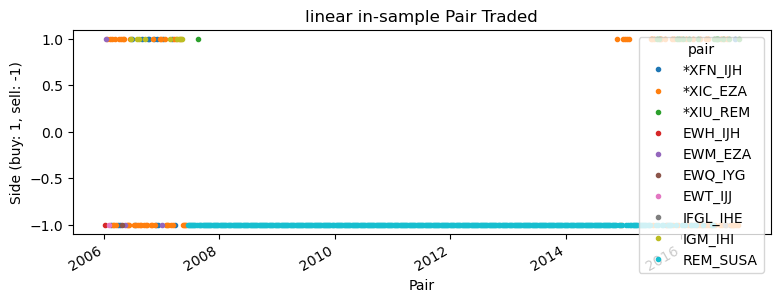

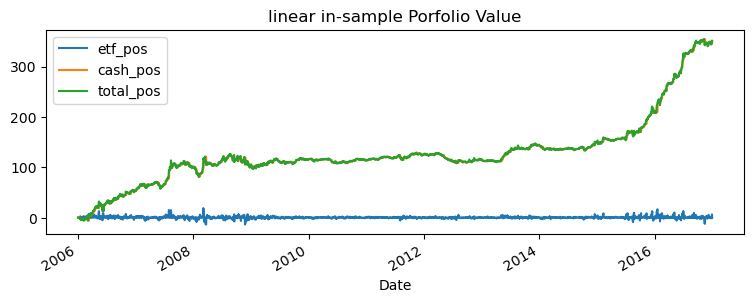

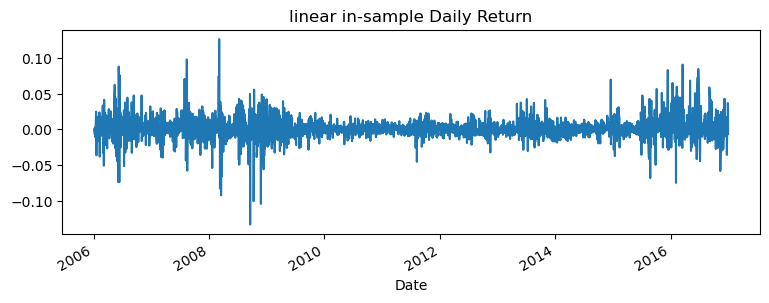

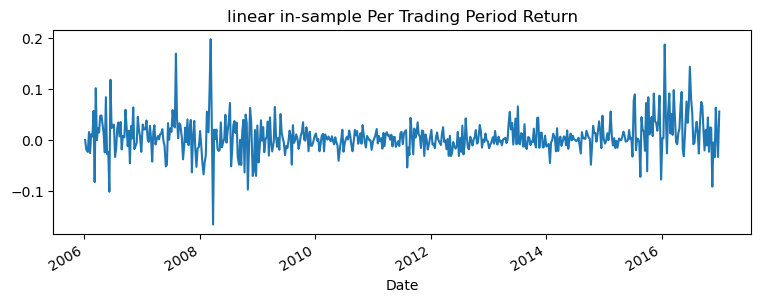

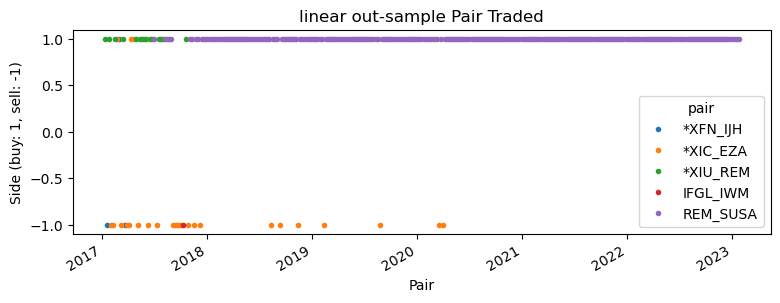

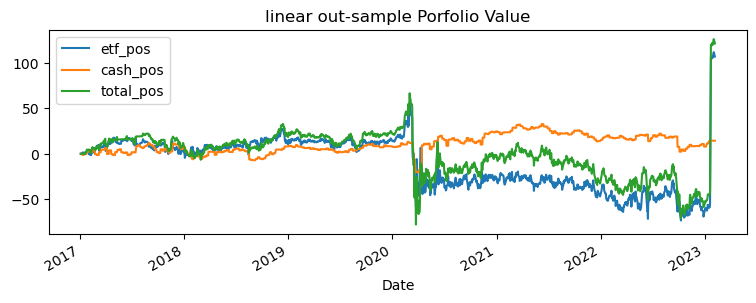

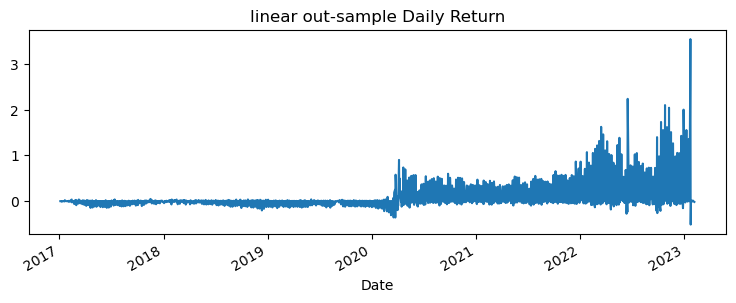

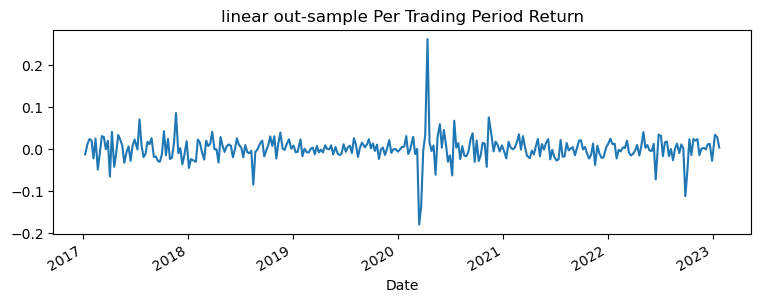

In [1495]:
pipeline.run('linear', params = {
                'pred_period': 'W',
                'cost' : 100,
                'holding_period': 5,
            })

In [ ]:
pipeline.signal_result

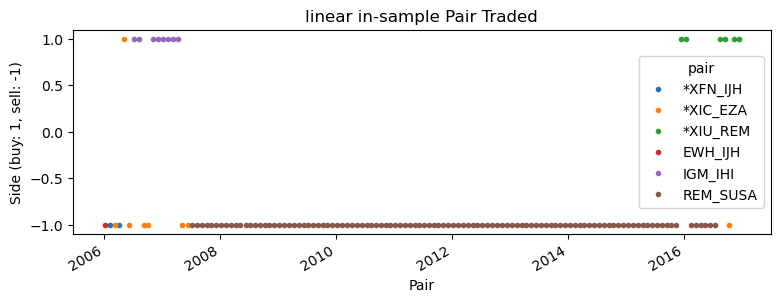

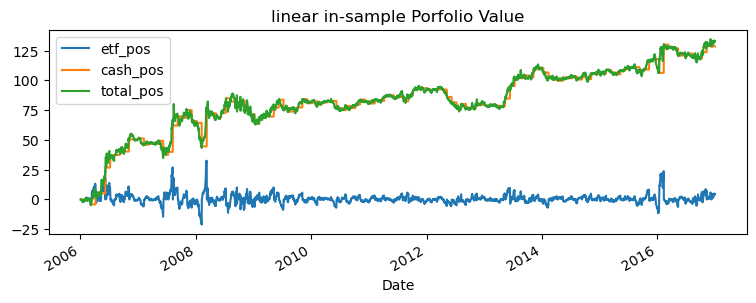

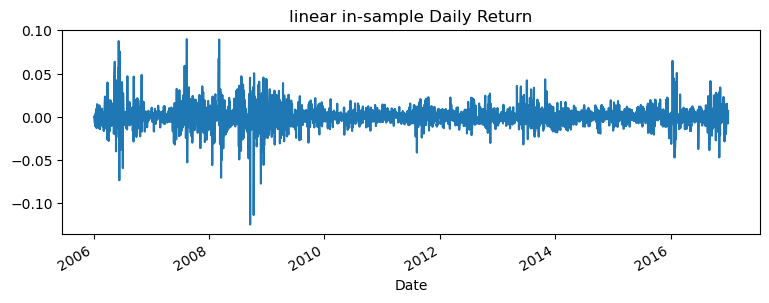

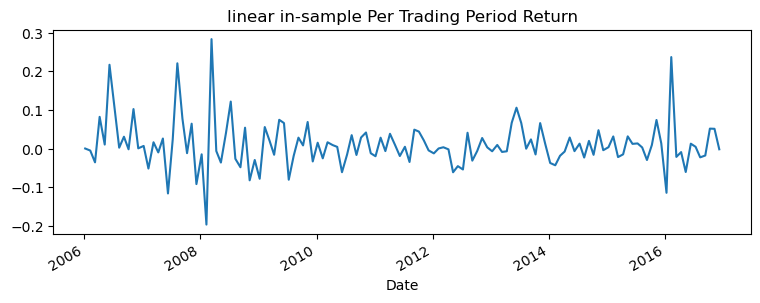

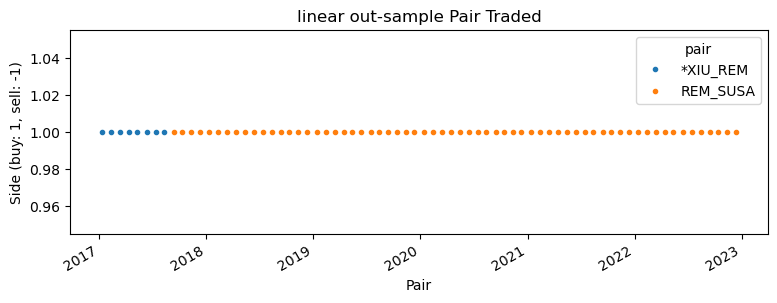

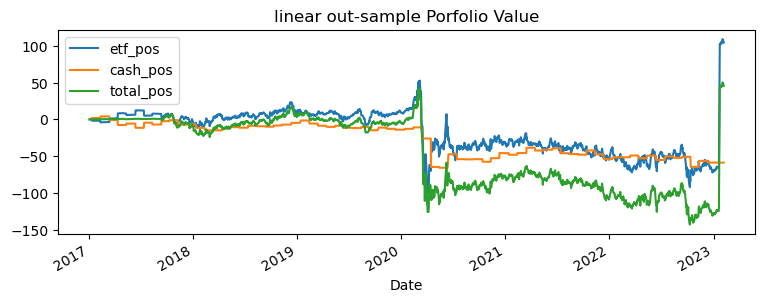

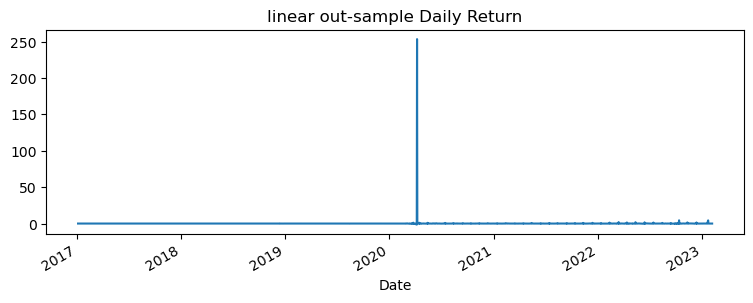

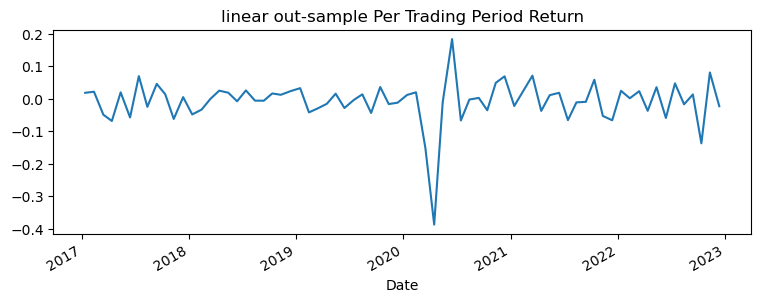

In [1496]:
pipeline.run('linear', params = {
                'pred_period': 'M',
                'cost' : 100,
                'holding_period': 21,
            })

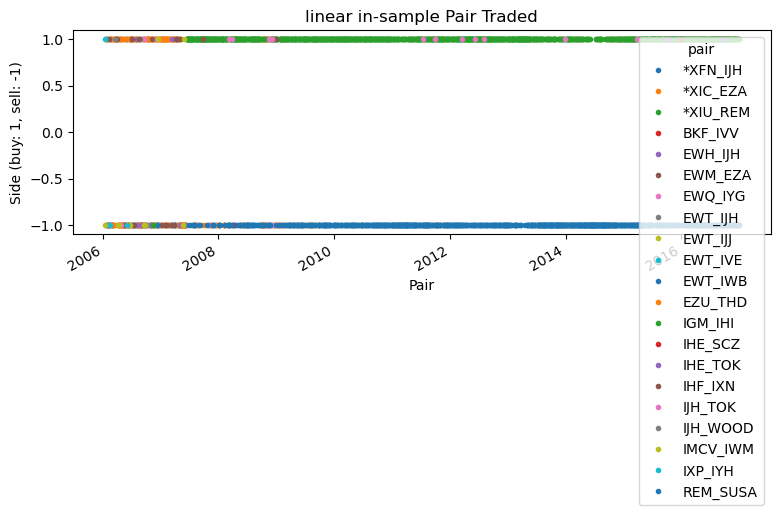

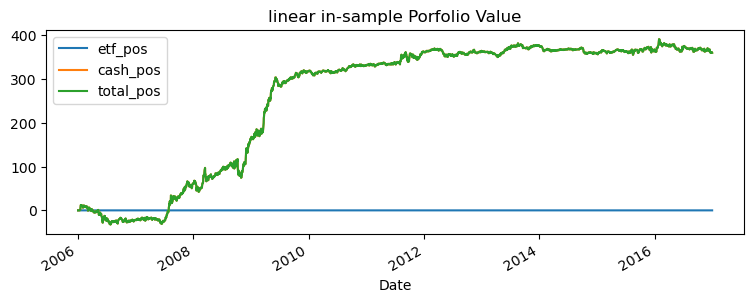

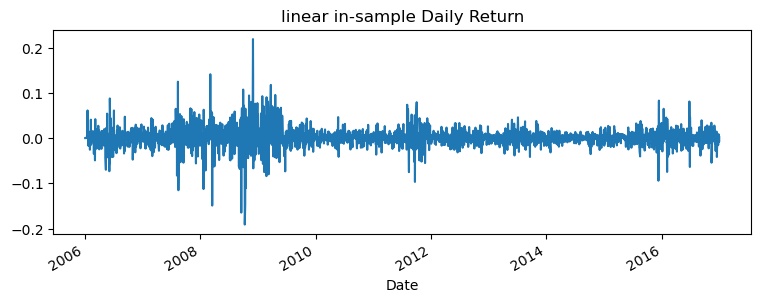

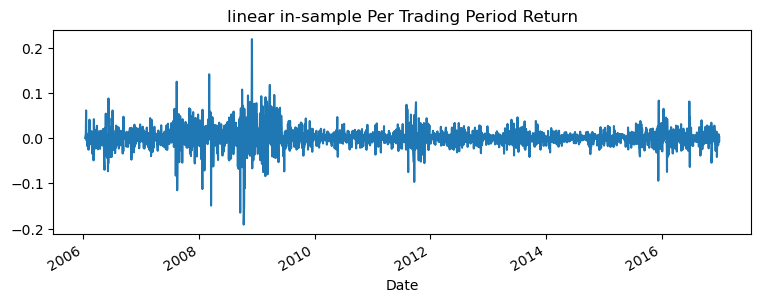

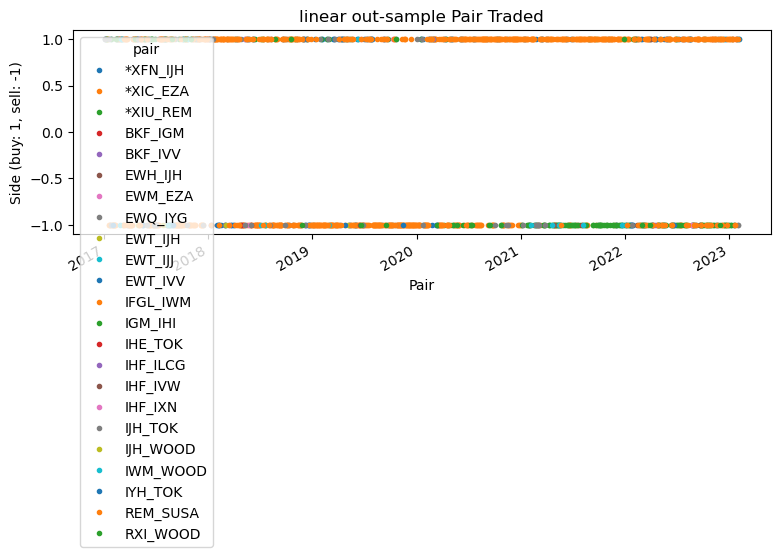

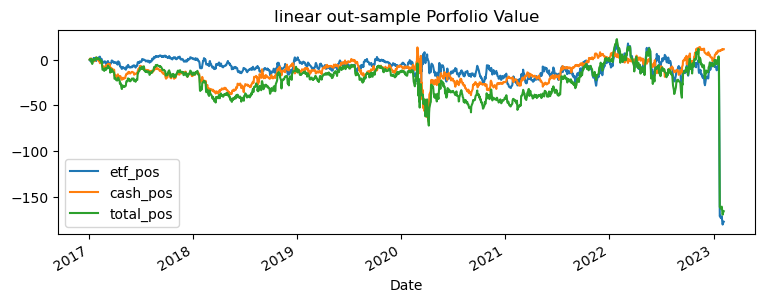

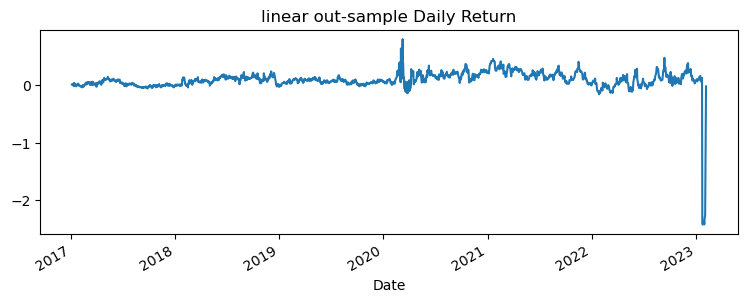

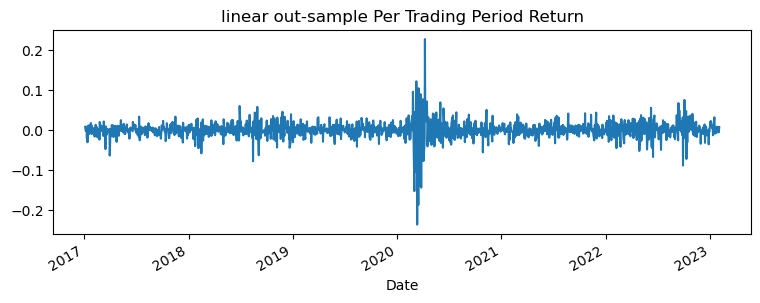

In [1497]:
pipeline.run('linear', periodic=True, params = {
                'pred_period': 'D',
                'cost' : 100,
                'holding_period': 1,
            })

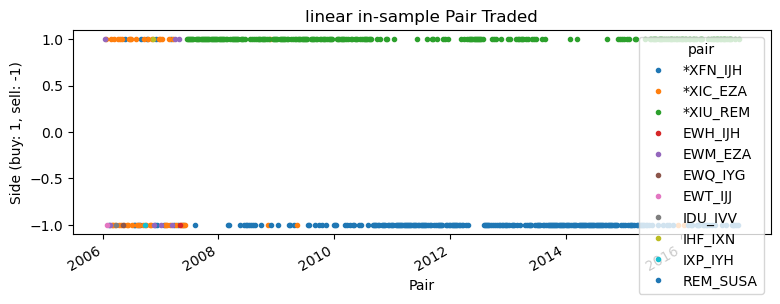

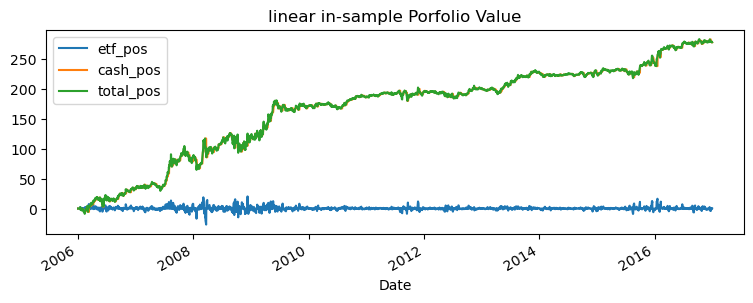

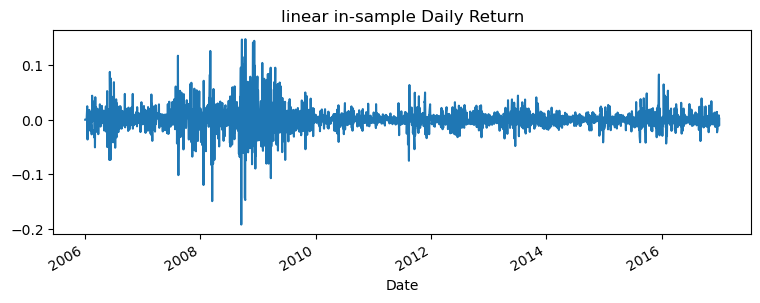

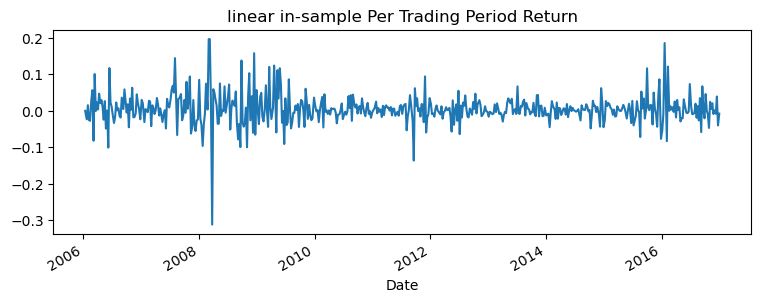

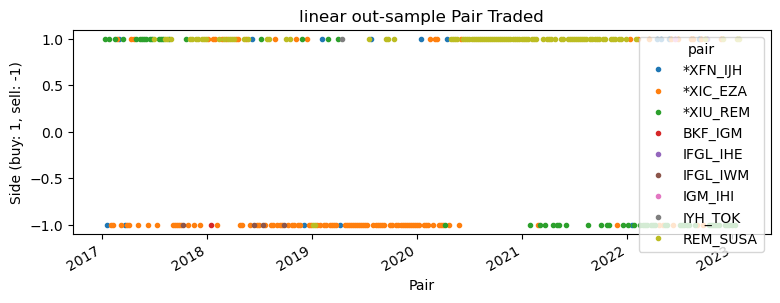

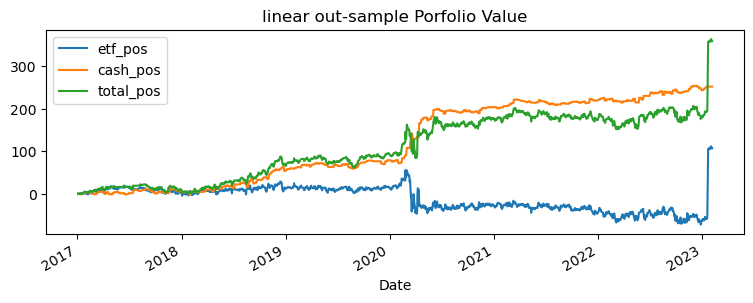

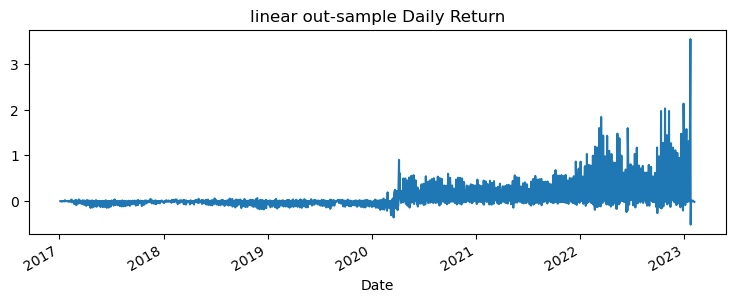

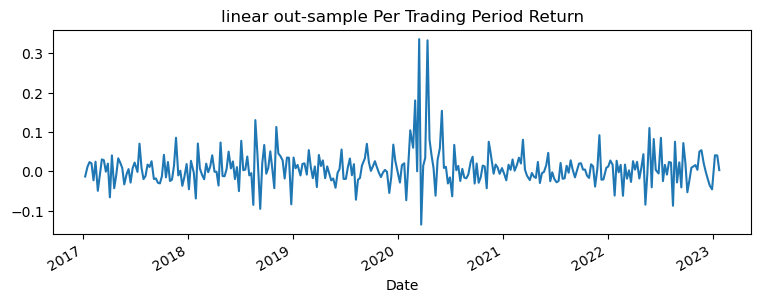

In [1498]:
pipeline.run('linear', periodic=True, params = {
                'pred_period': 'W',
                'cost' : 100,
                'holding_period': 5,
            })

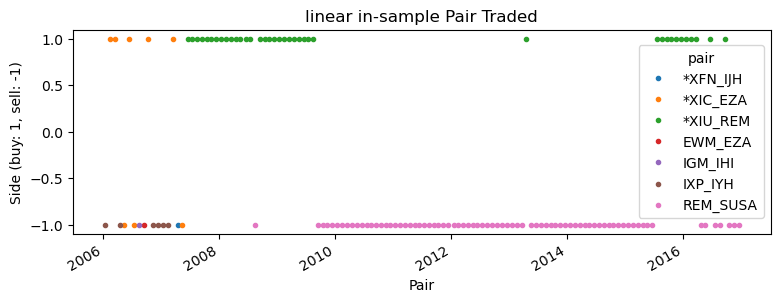

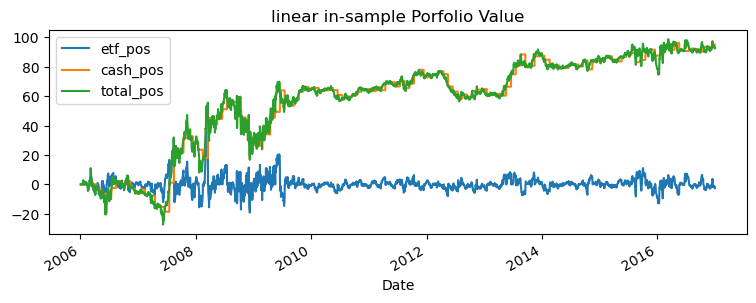

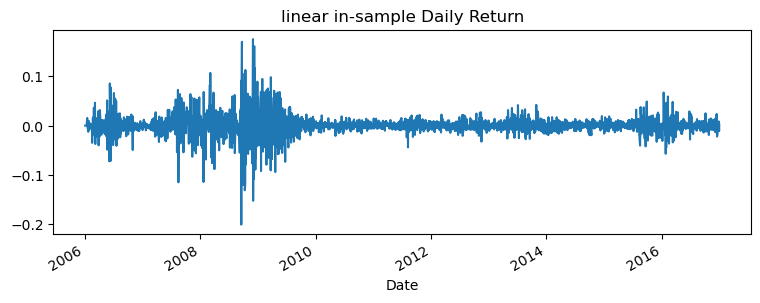

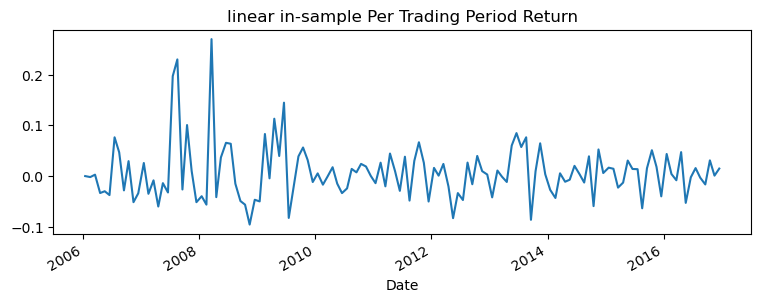

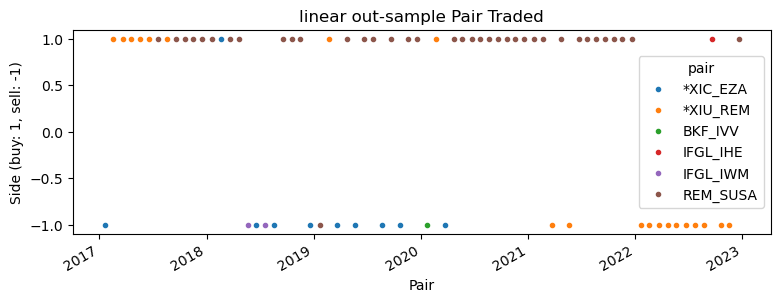

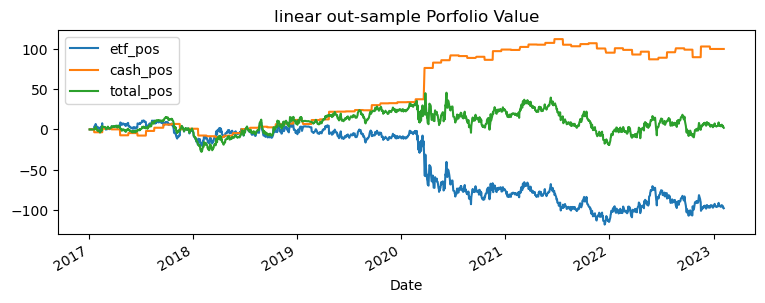

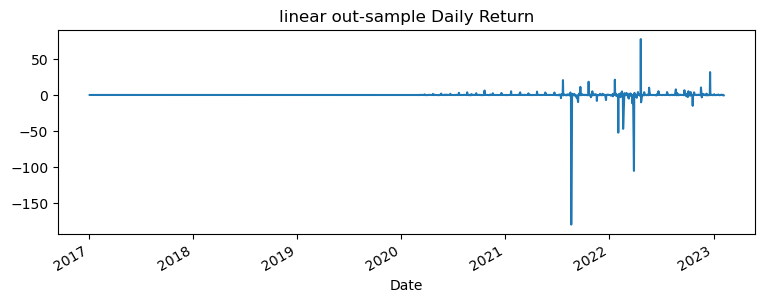

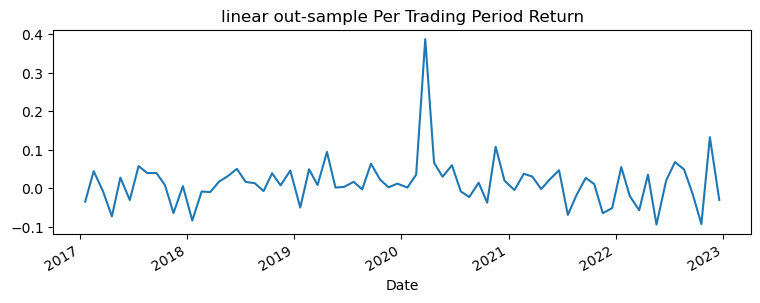

In [1499]:
pipeline.run('linear', periodic=True, params = {
                'pred_period': 'M',
                'cost' : 100,
                'holding_period': 21,
            })

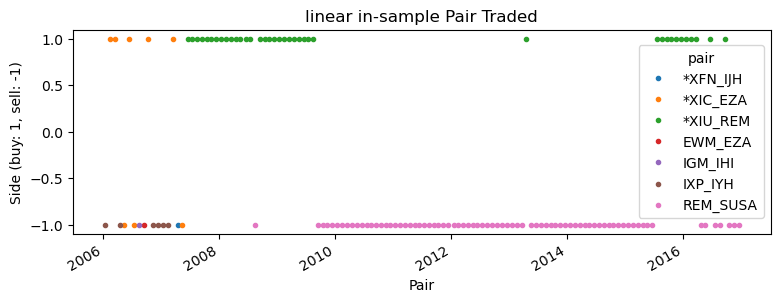

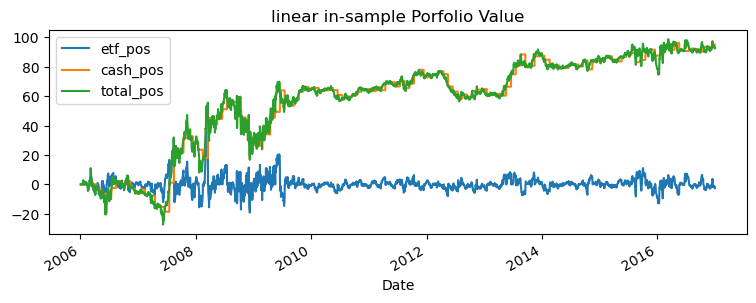

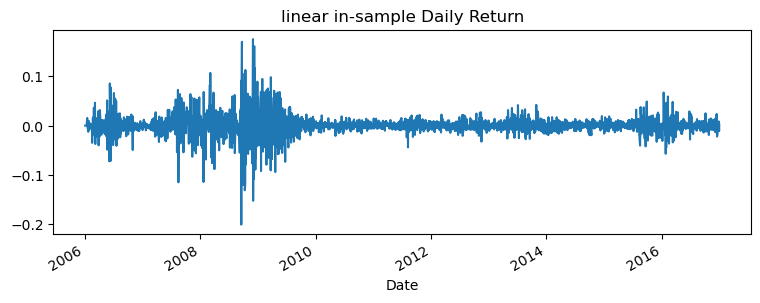

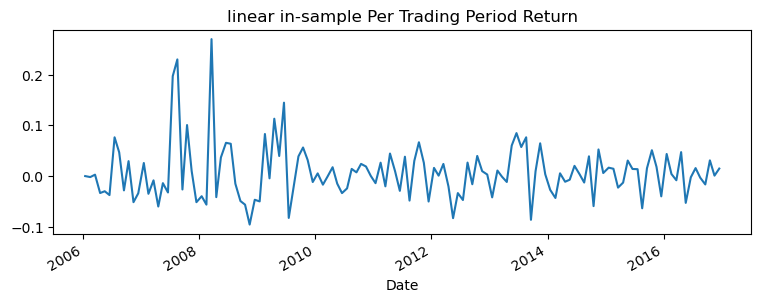

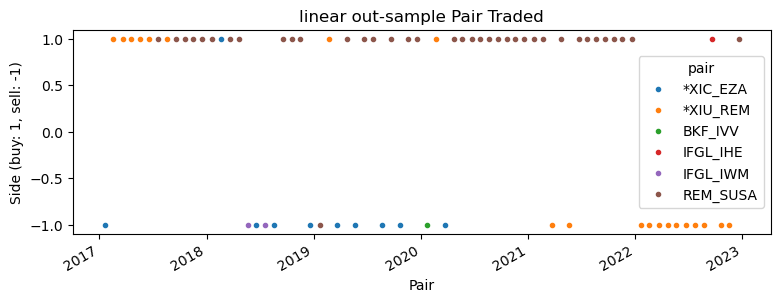

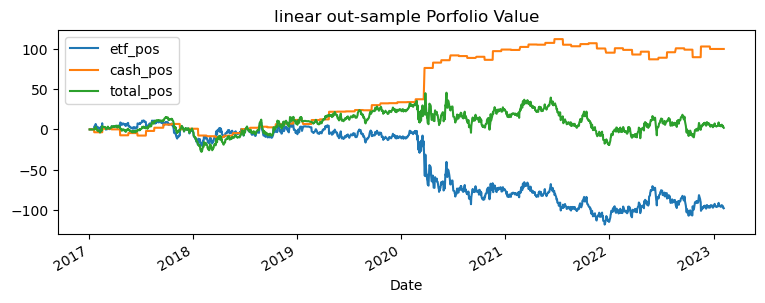

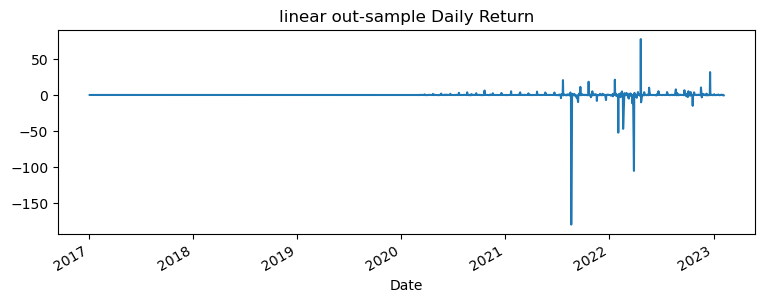

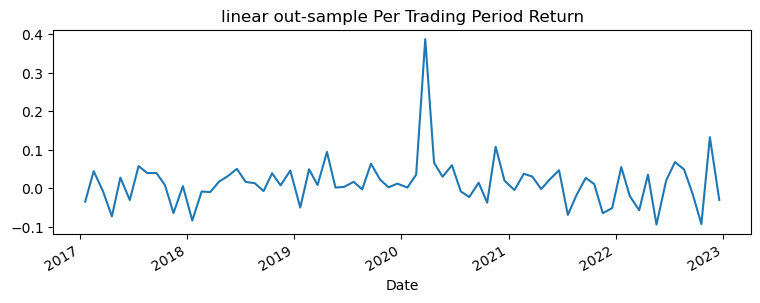

In [1500]:
pipeline.run('linear', periodic=True, params = {
                'pred_period': 'M',
                'cost' : 100,
                'holding_period': 21,
            })

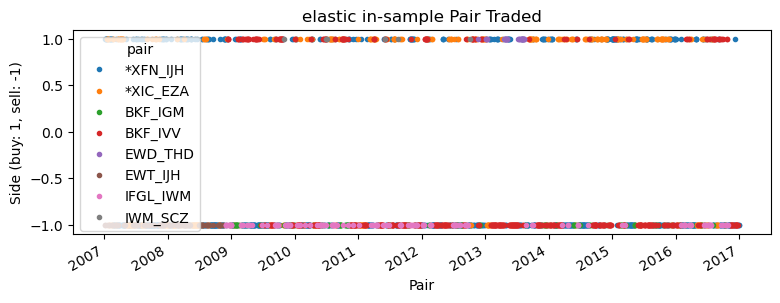

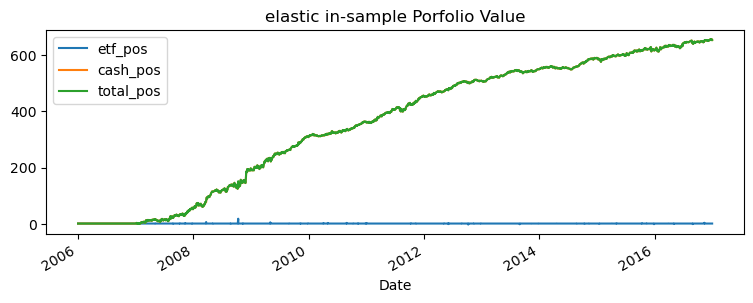

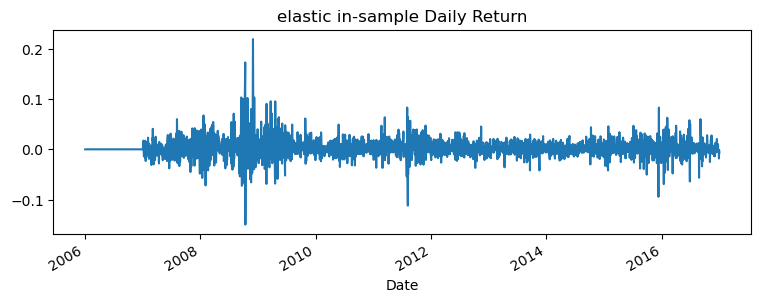

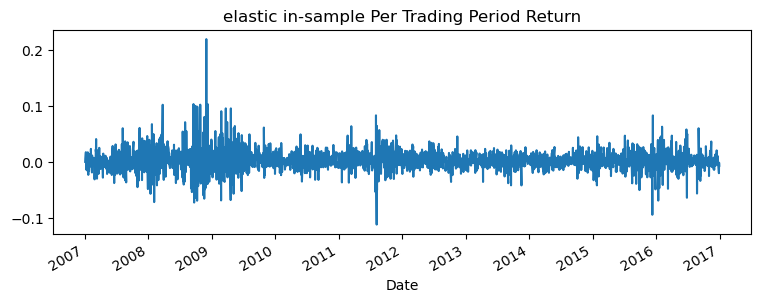

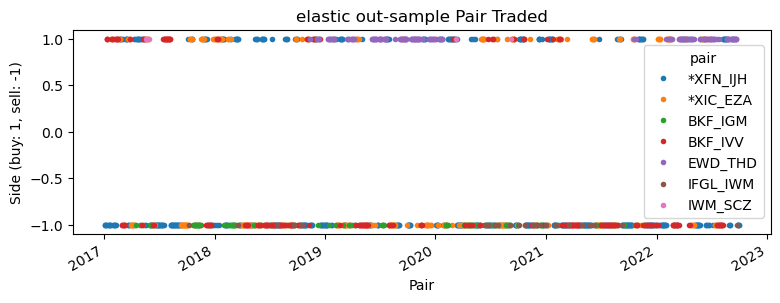

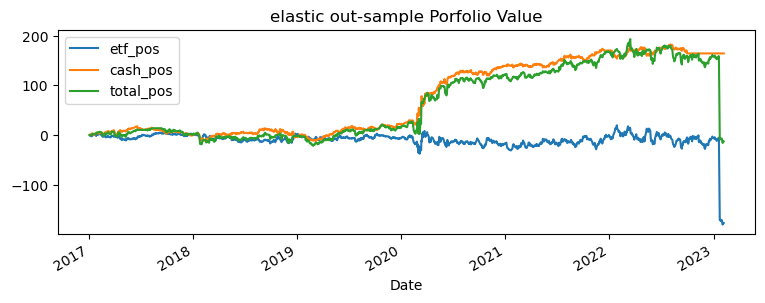

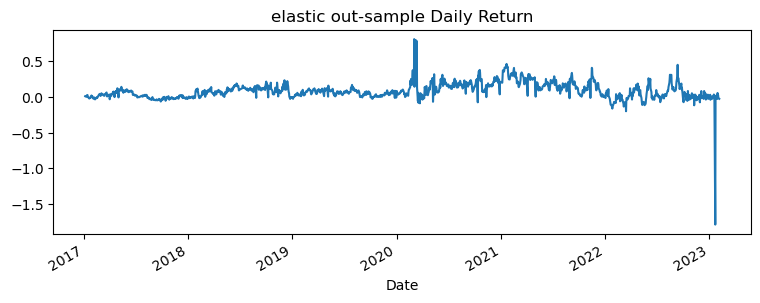

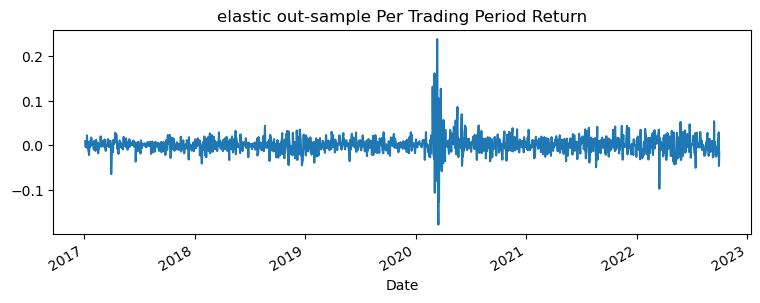

In [1501]:
pipeline.run('elastic', params = {
                'pred_period': 'D',
                'cost' : 100,
                'holding_period': 1,
            })

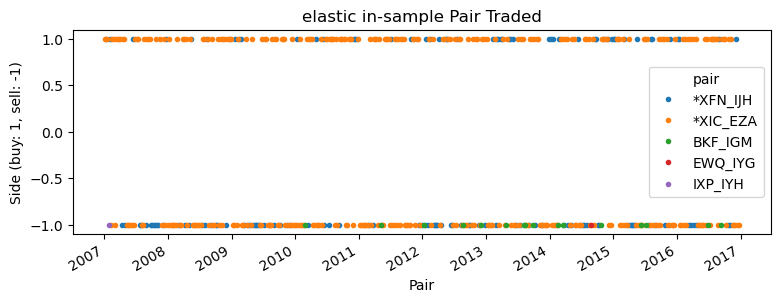

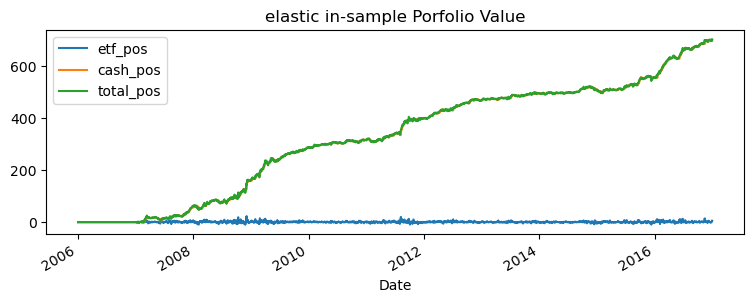

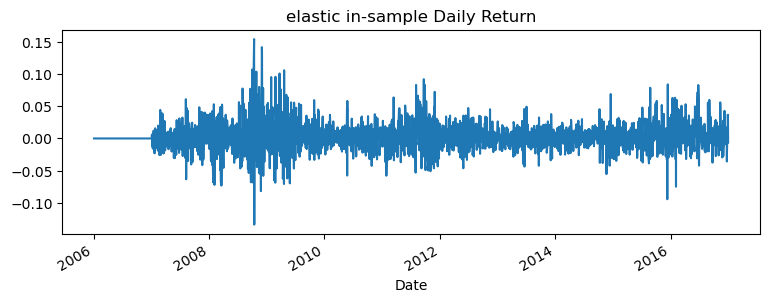

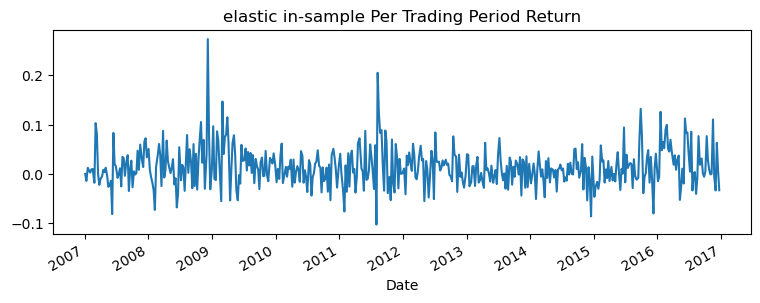

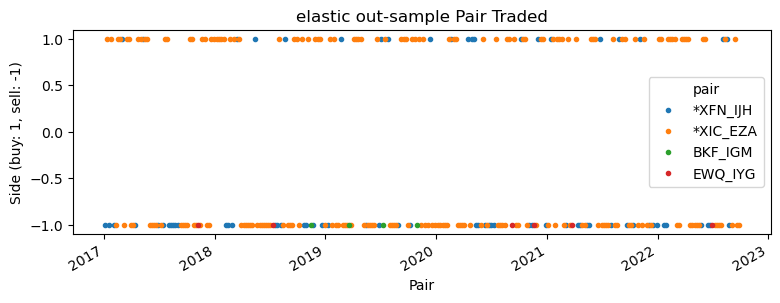

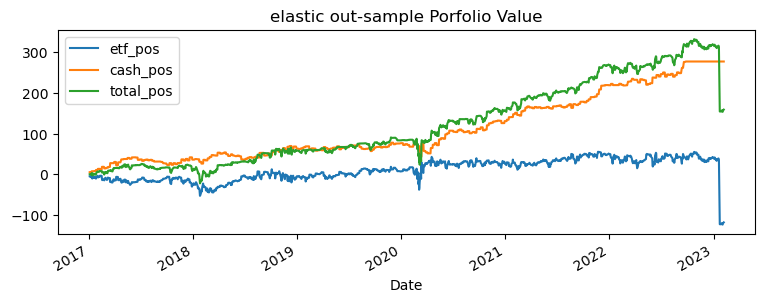

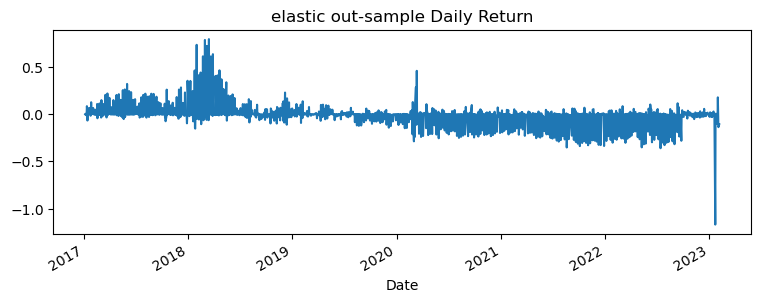

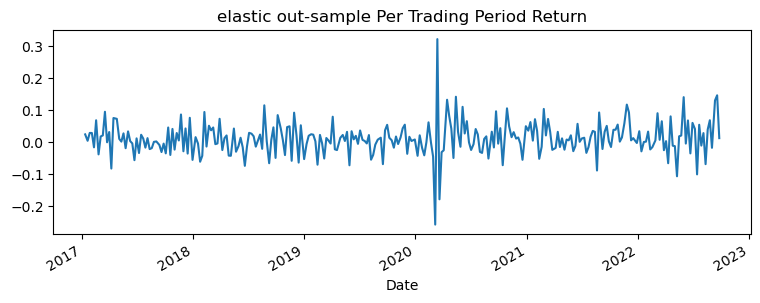

In [1502]:
pipeline.run('elastic', params = {
                'pred_period': 'W',
                'cost' : 100,
                'holding_period': 5,
            })

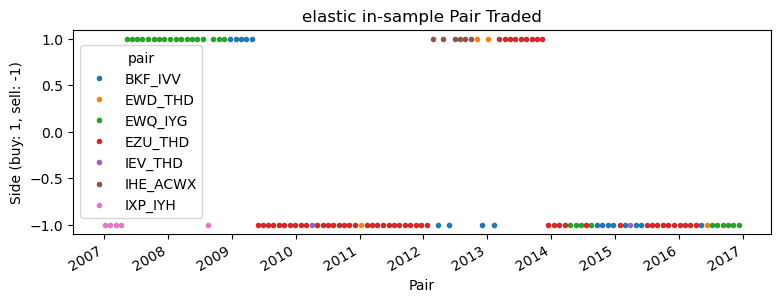

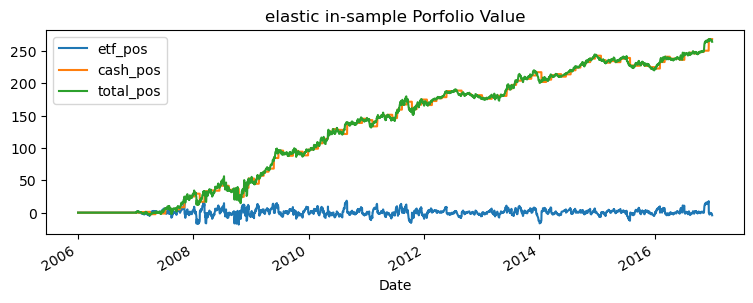

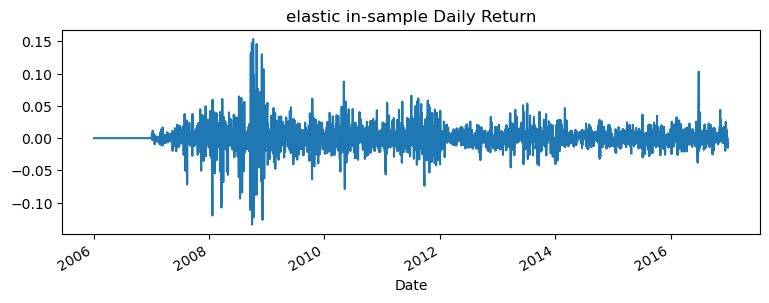

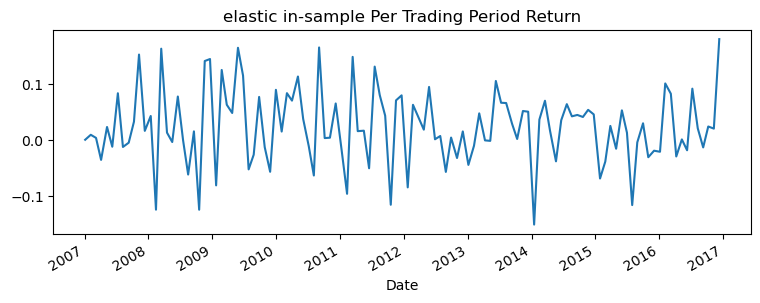

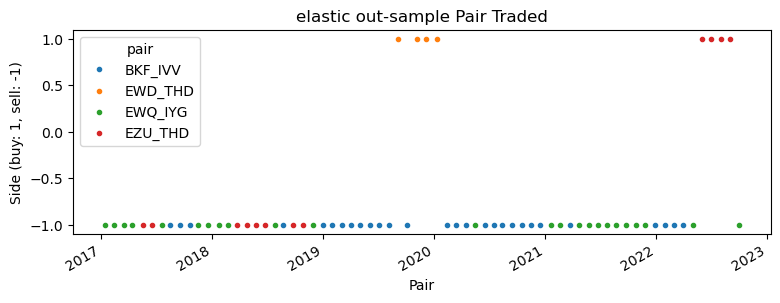

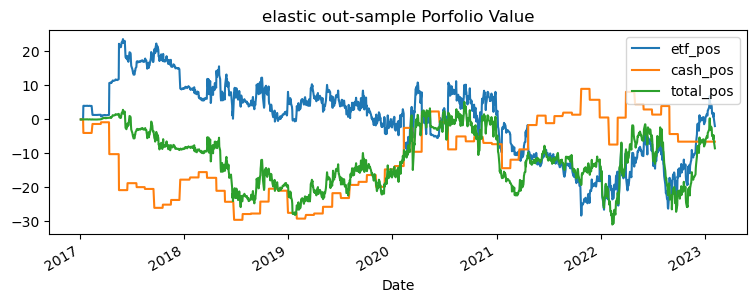

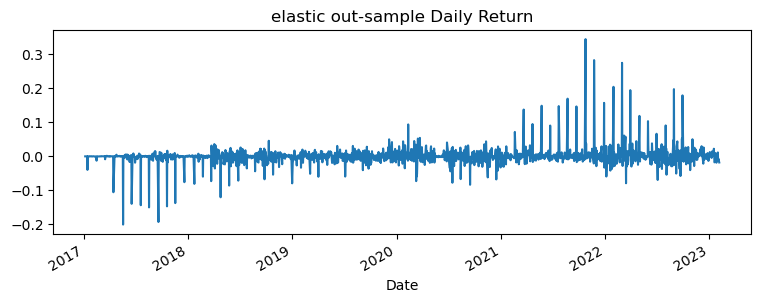

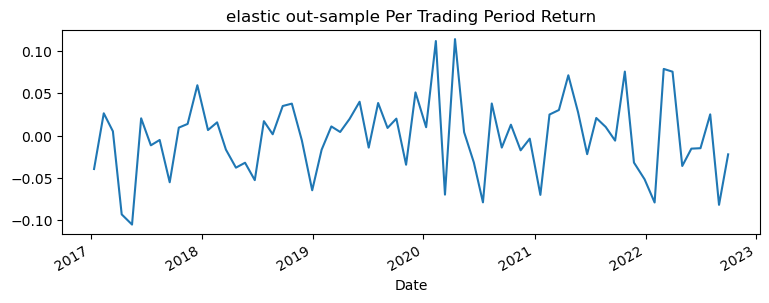

In [1503]:
pipeline.run('elastic', params = {
                'pred_period': 'M',
                'cost' : 100,
                'holding_period': 21,
            })

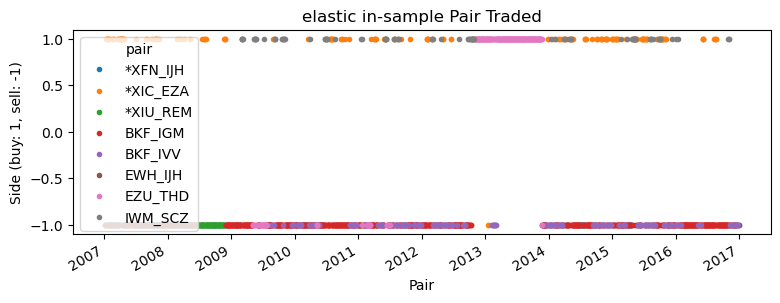

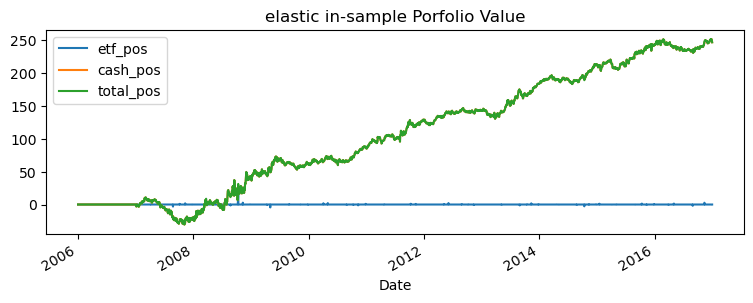

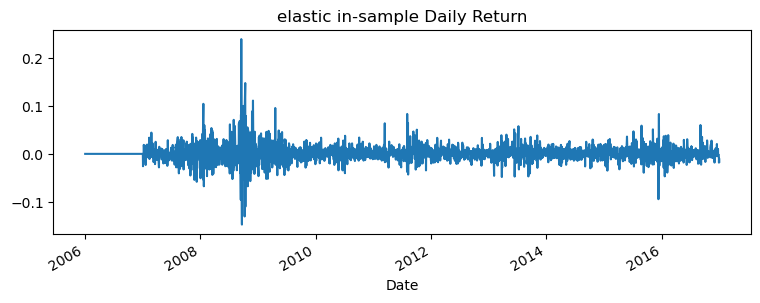

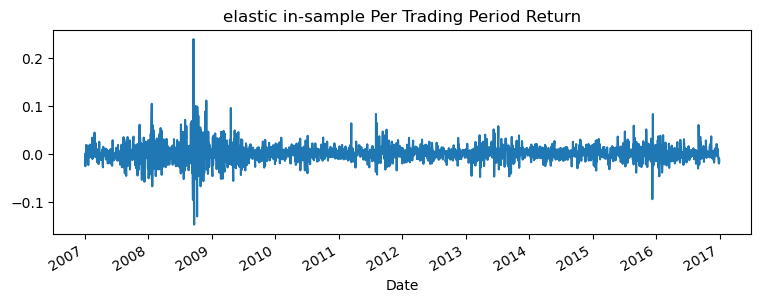

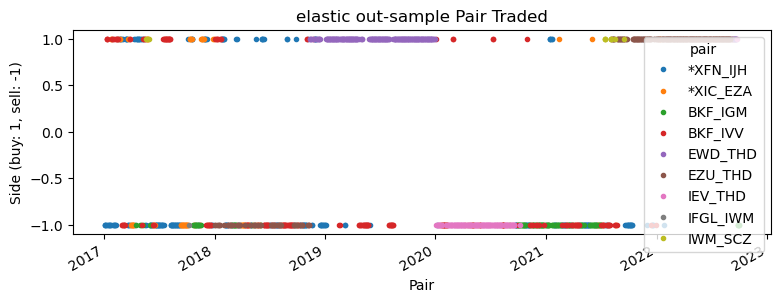

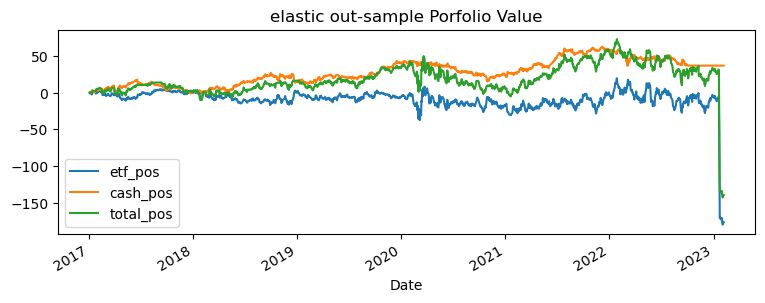

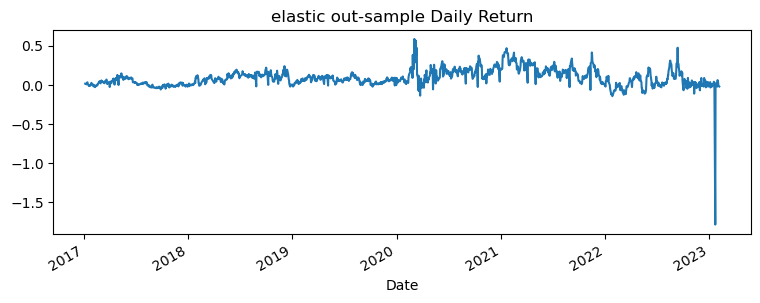

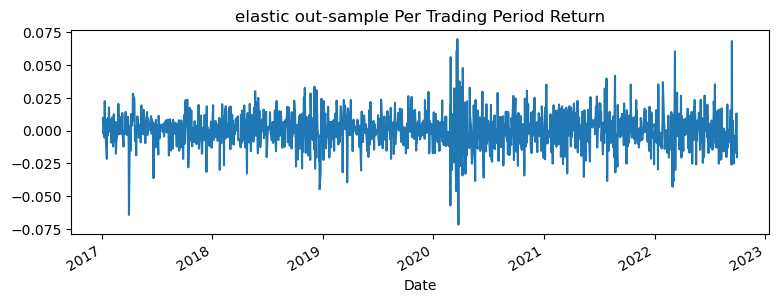

In [1504]:
pipeline.run('elastic', periodic=True, params = {
                'pred_period': 'D',
                'cost' : 100,
                'holding_period': 1,
            })

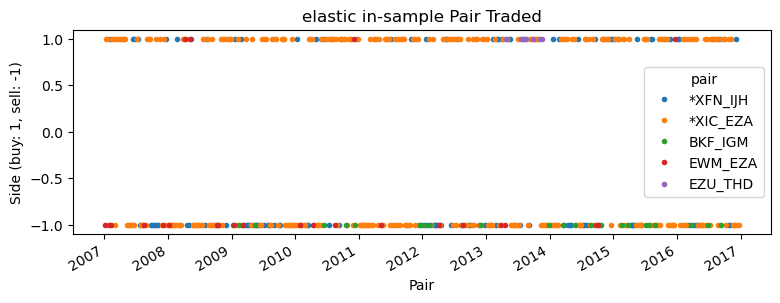

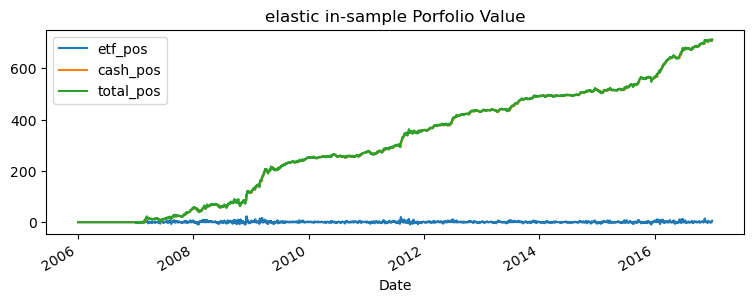

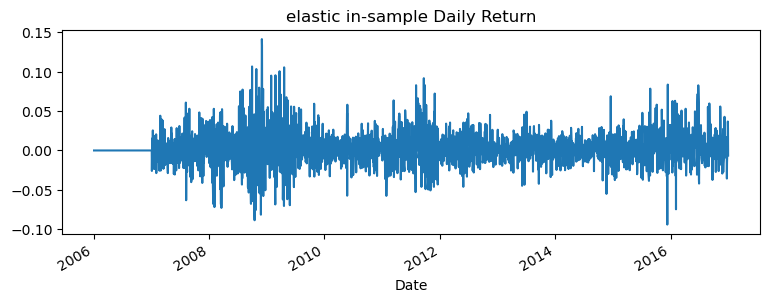

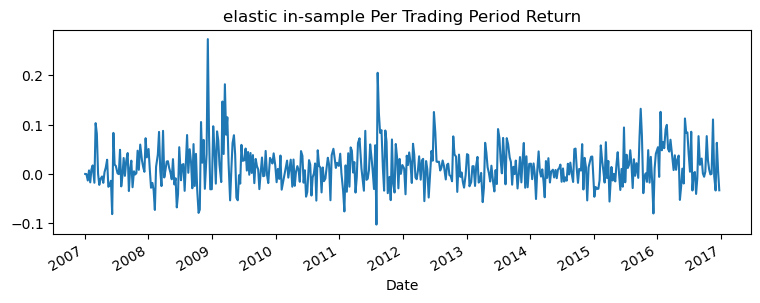

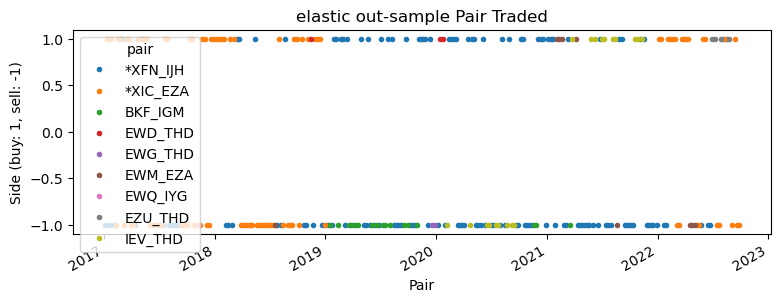

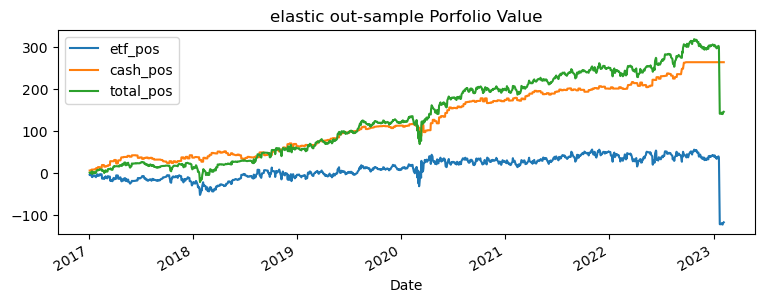

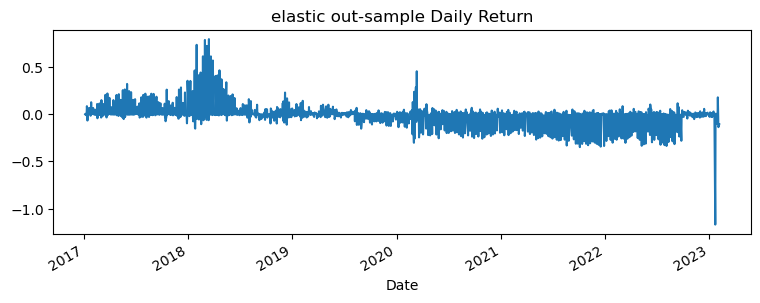

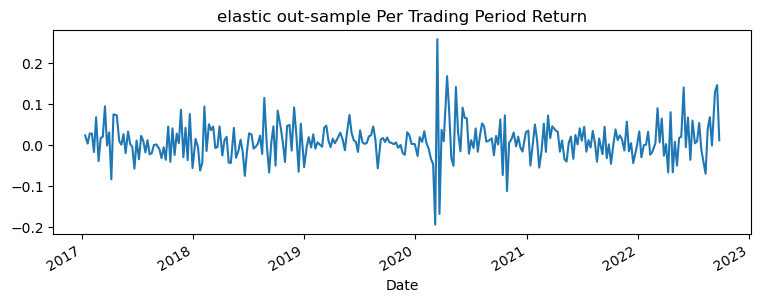

In [1505]:
pipeline.run('elastic', periodic=True, params = {
                'pred_period': 'W',
                'cost' : 100,
                'holding_period': 5,
            })

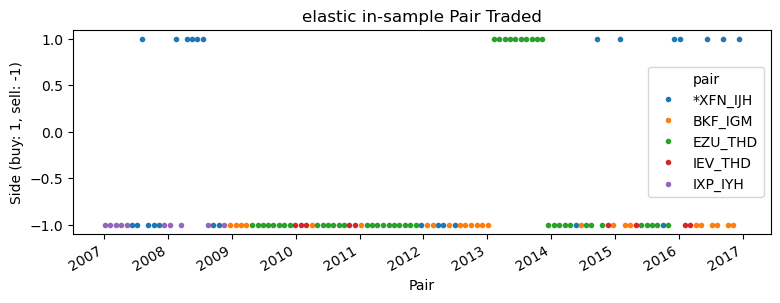

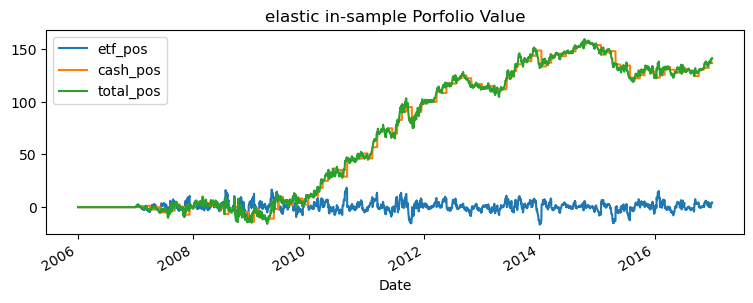

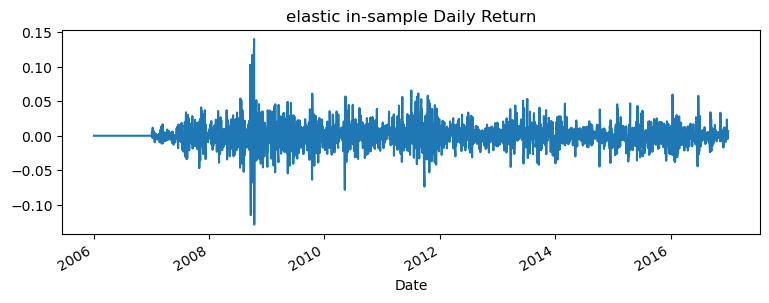

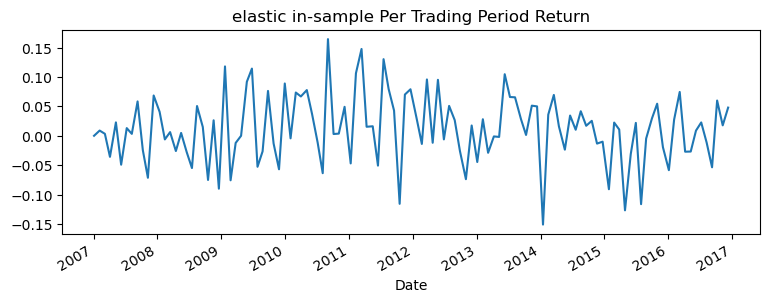

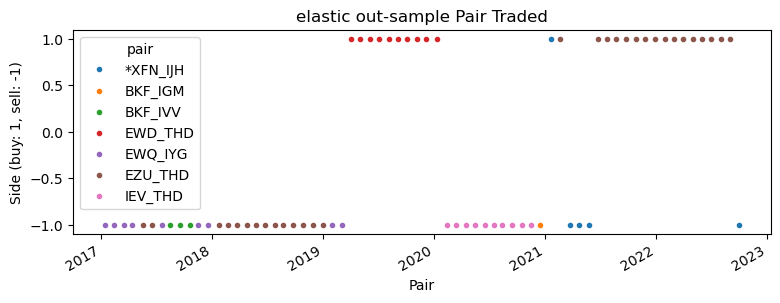

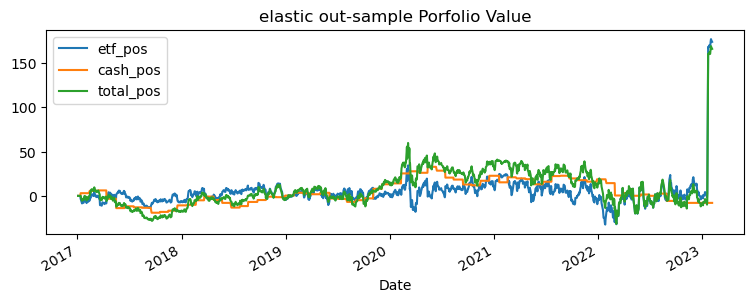

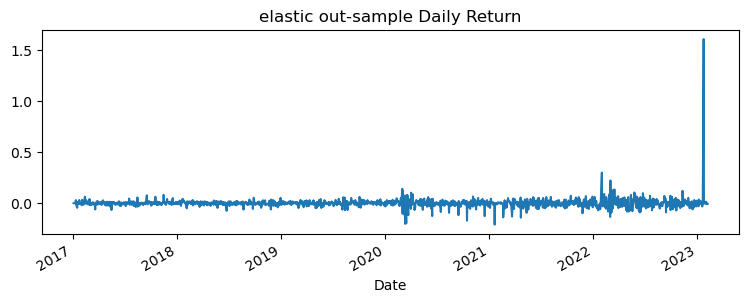

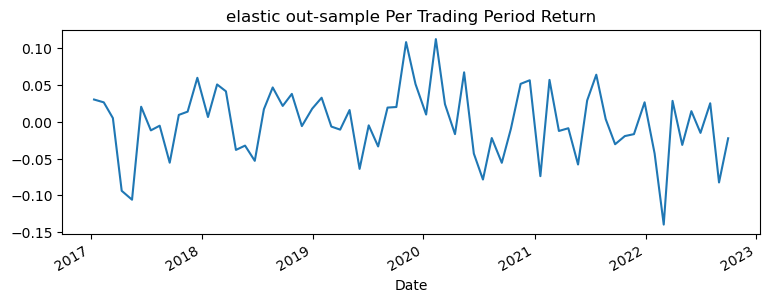

In [1506]:
pipeline.run('elastic', periodic=True, params = {
                'pred_period': 'M',
                'cost' : 100,
                'holding_period': 21,
            })

In [1507]:
# pipeline.run('XGB', params = {
#                 'pred_period': 'D',
#                 'cost' : 100,
#                 'holding_period': 1,
#             })

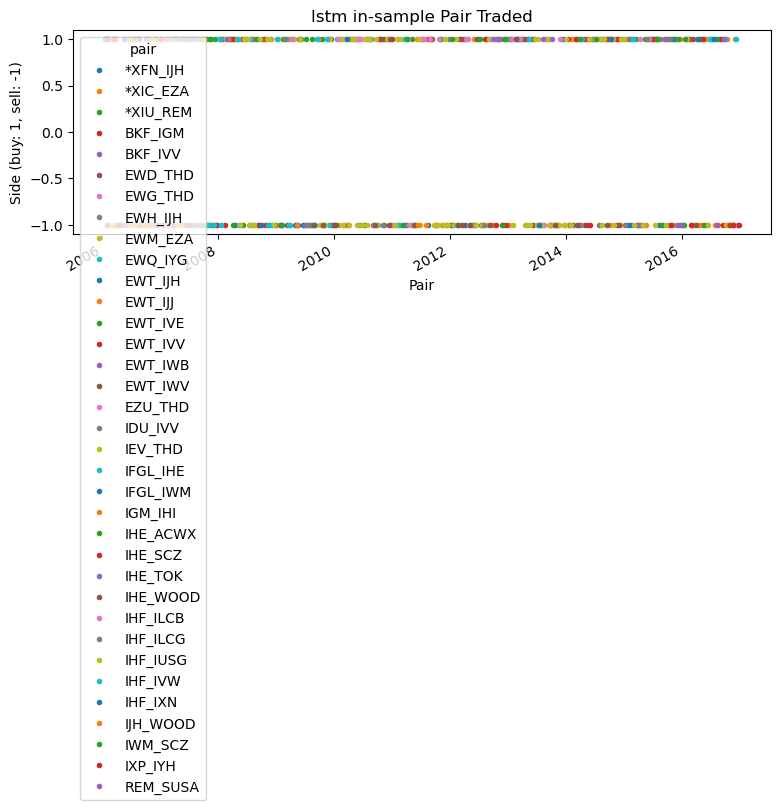

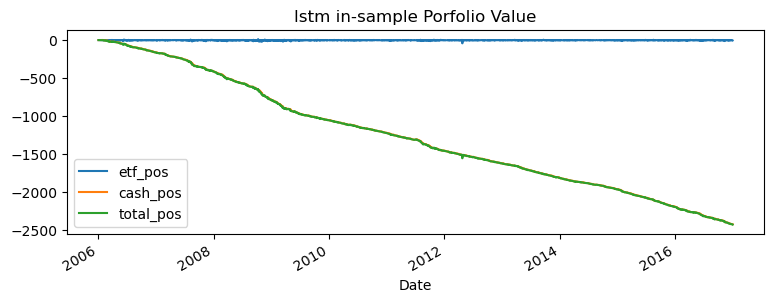

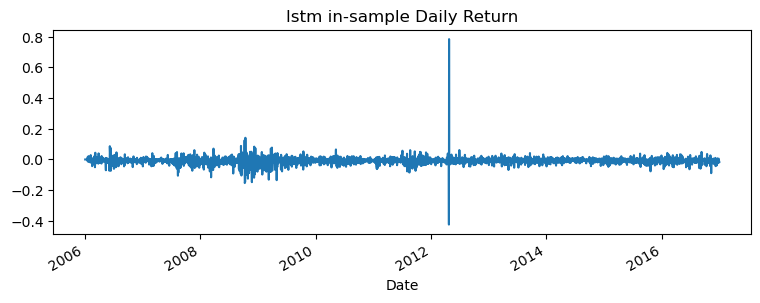

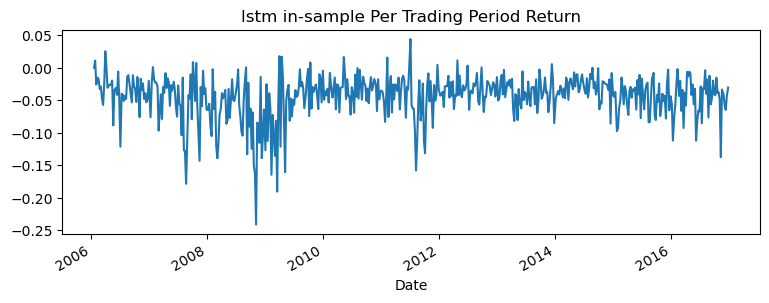

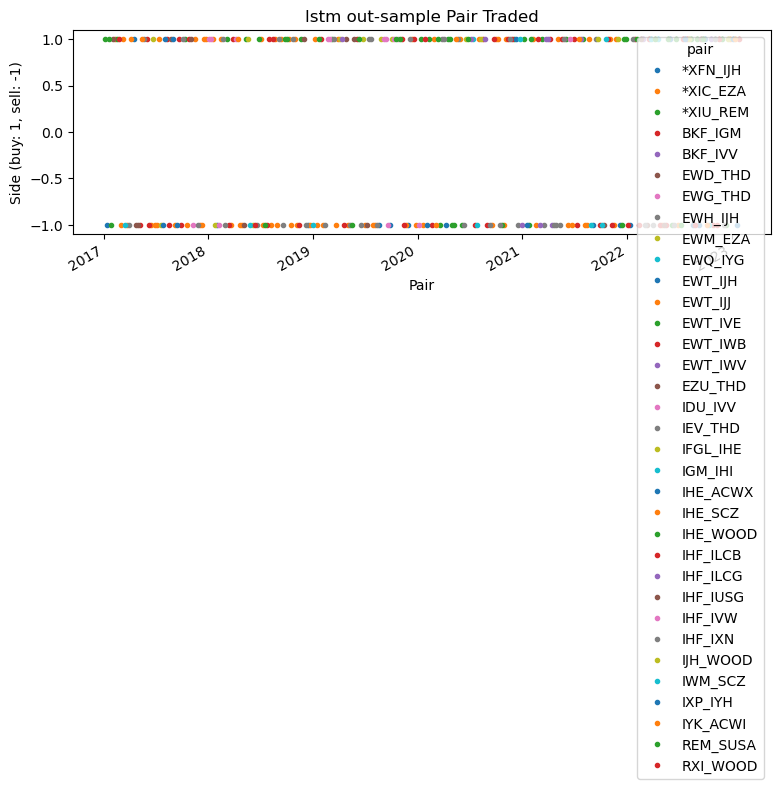

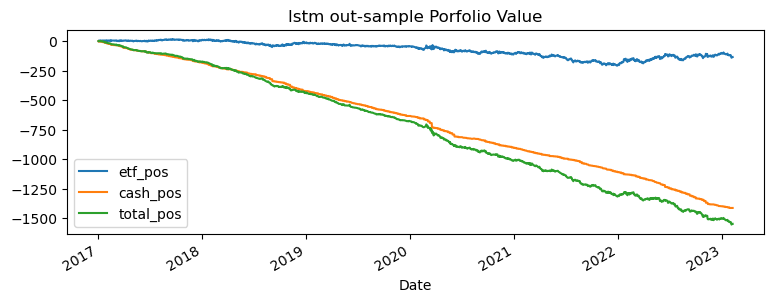

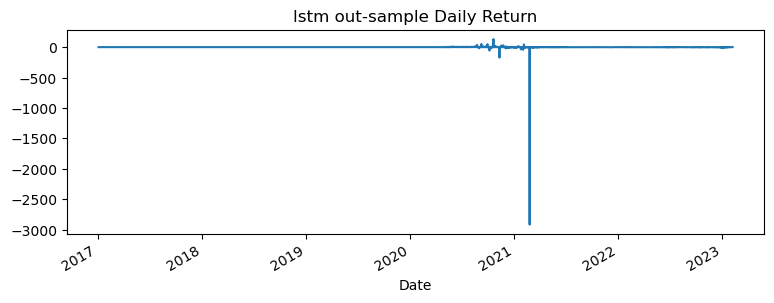

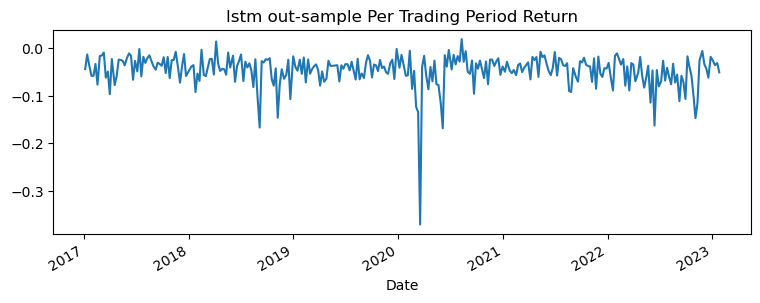

In [1508]:
pipeline.run('lstm', params = {
                'pred_period': 'W',
                'cost' : 100,
                'holding_period': 5,
            })

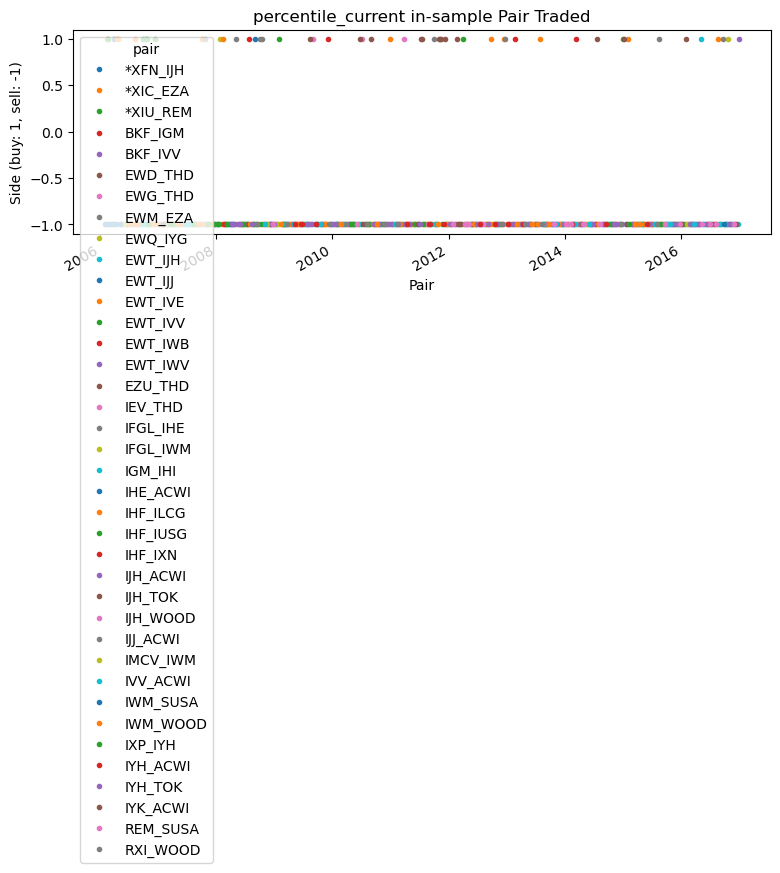

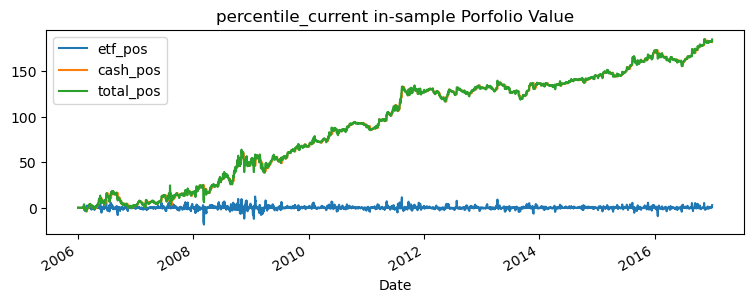

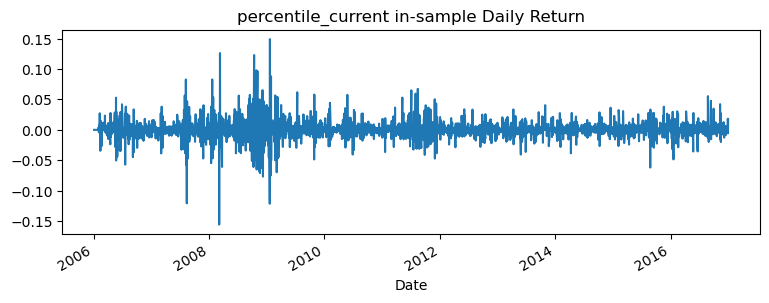

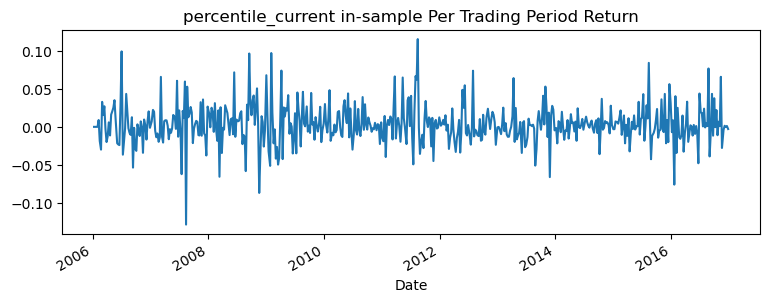

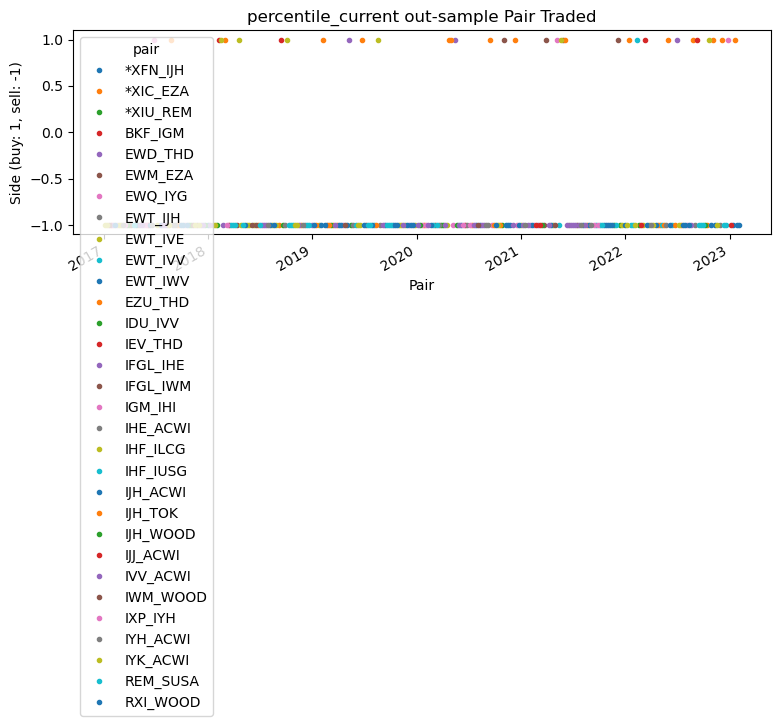

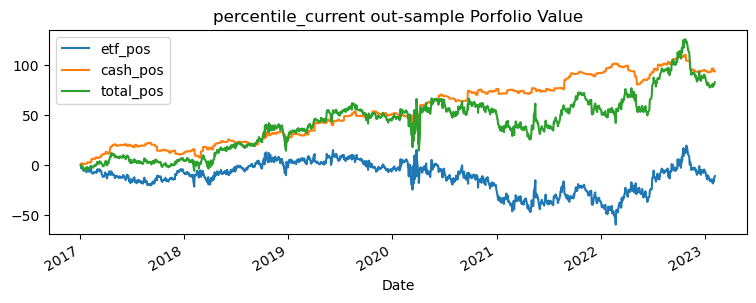

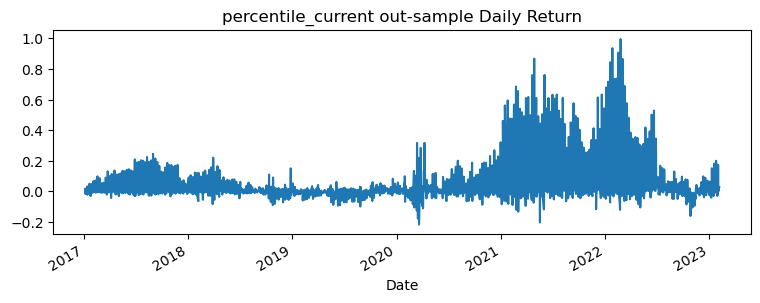

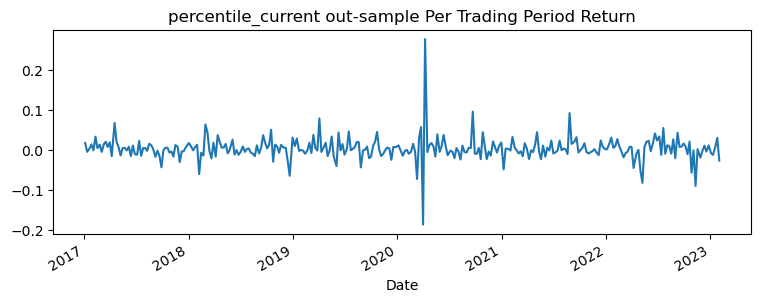

In [1509]:
pipeline.run('percentile_current', params = {
                'pred_period': 'W',
                'holding_period': 5,
                'distribution_period': 21,
                'training_period':2769,
                'periodic': False,
                'cost': 100
            }, currentMode=True)


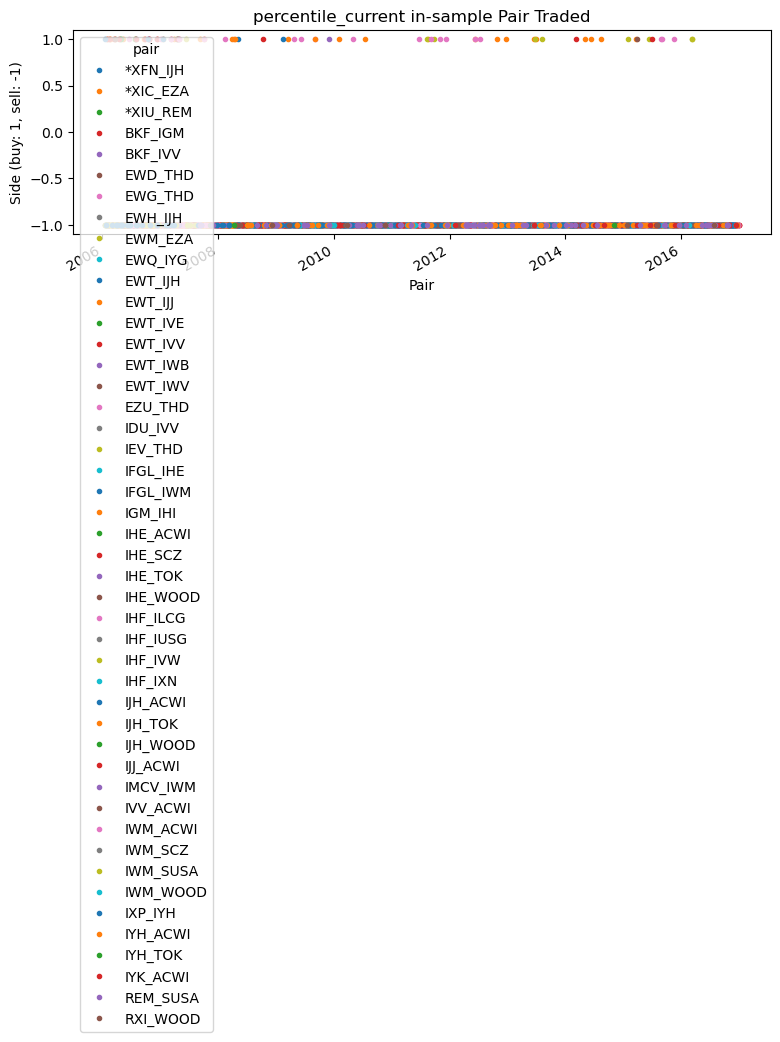

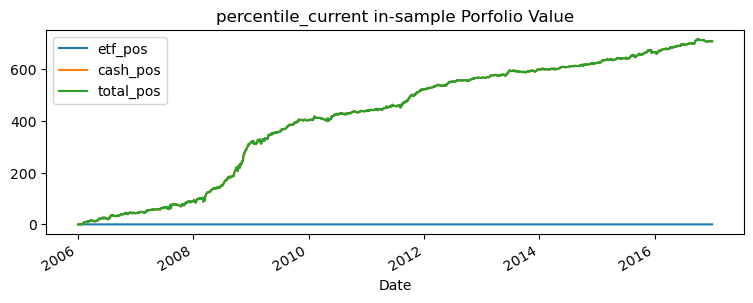

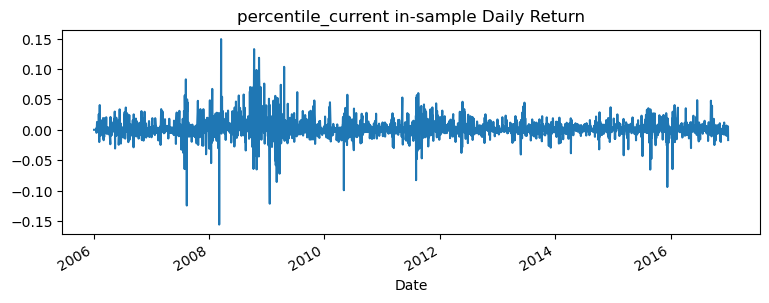

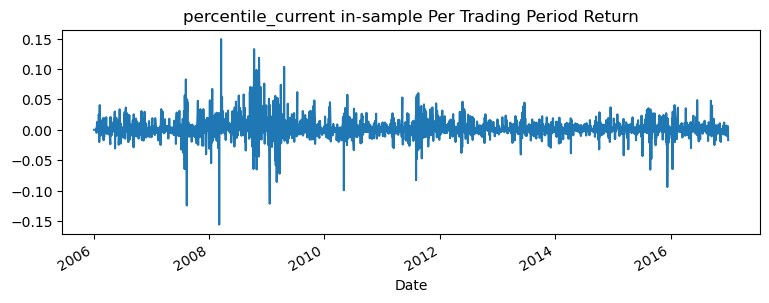

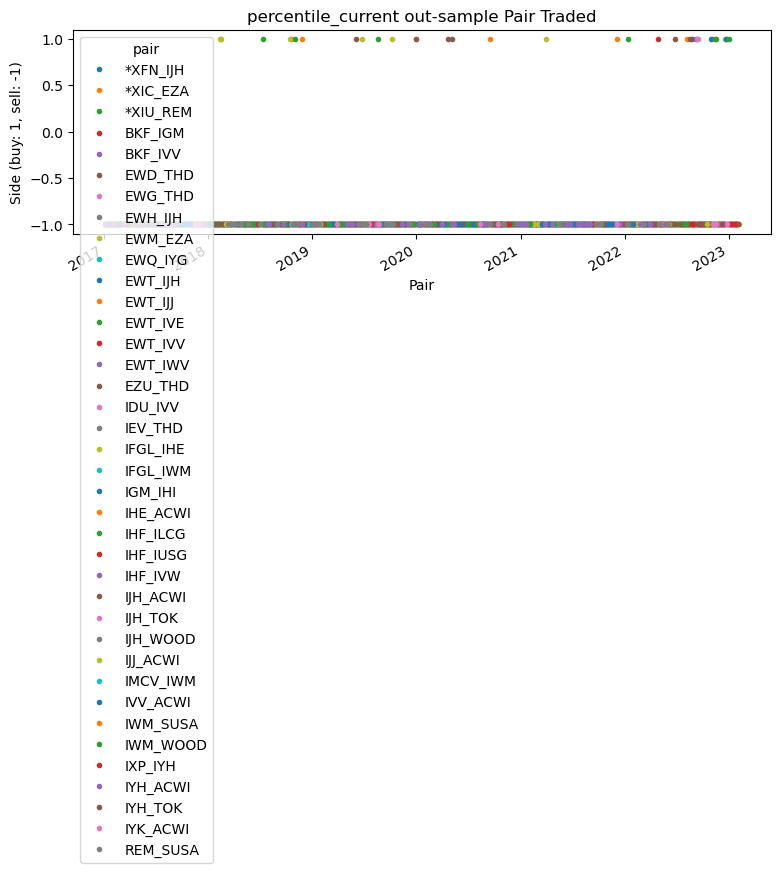

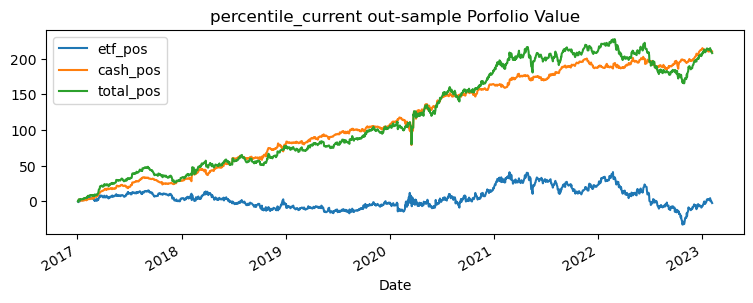

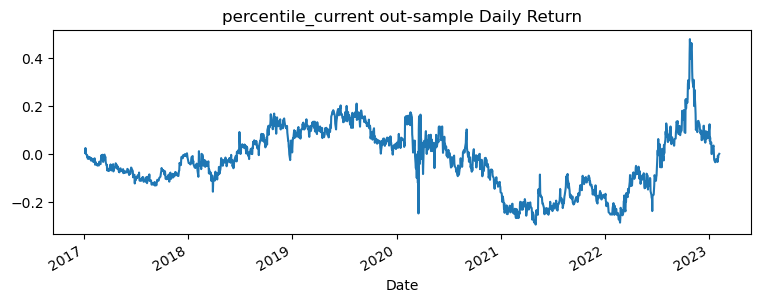

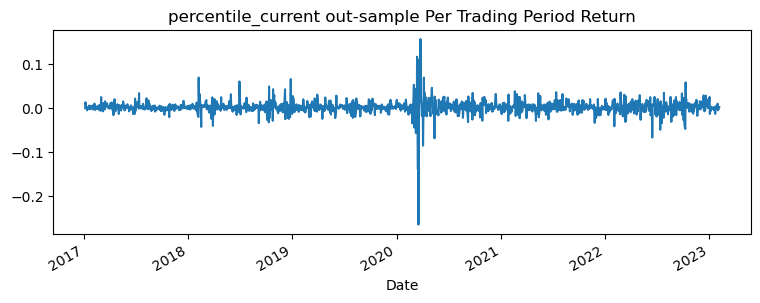

In [1510]:
pipeline.run('percentile_current', params = {
                'pred_period': 'D',
                'holding_period': 1,
                'distribution_period': 10,
                'training_period':2769,
                'periodic': False,
                'cost': 100
            }, currentMode=True)

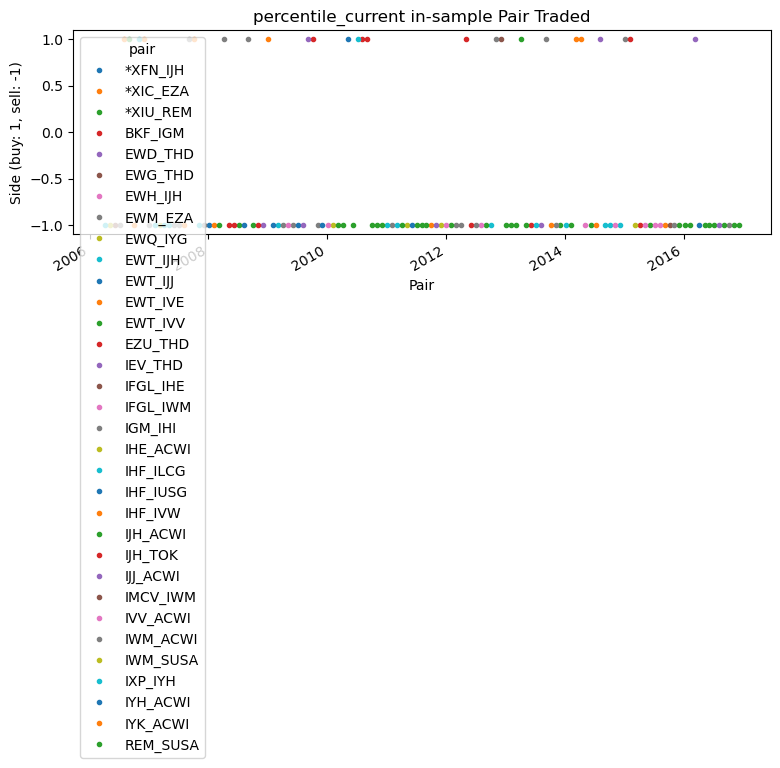

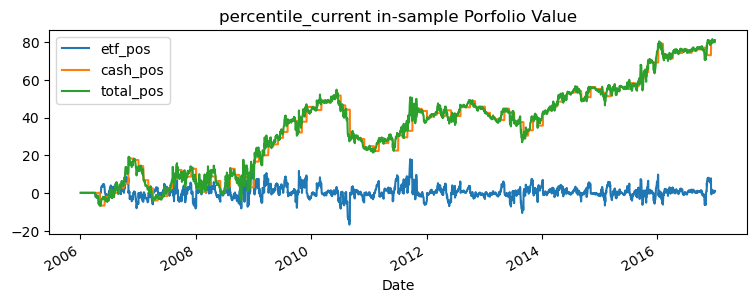

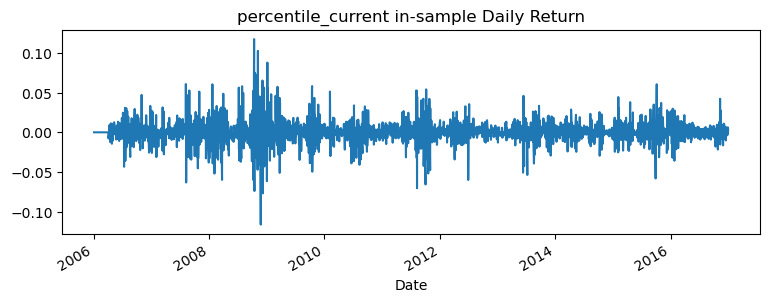

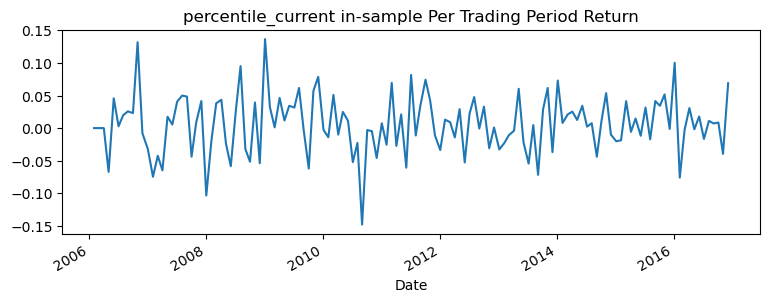

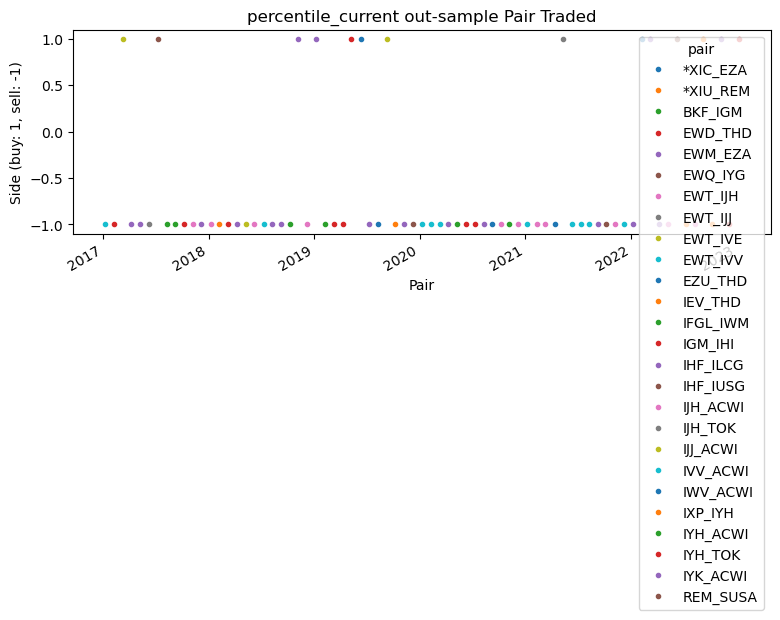

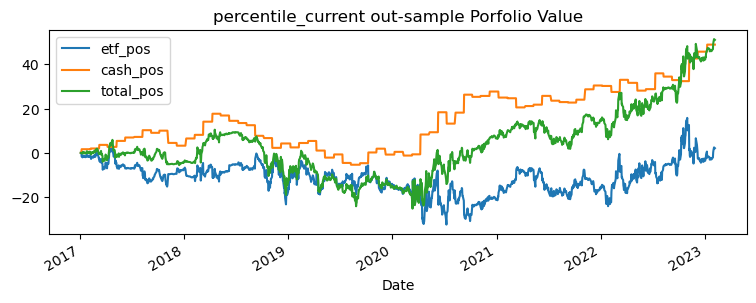

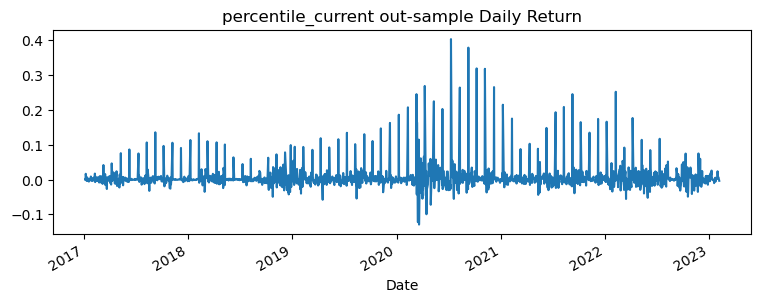

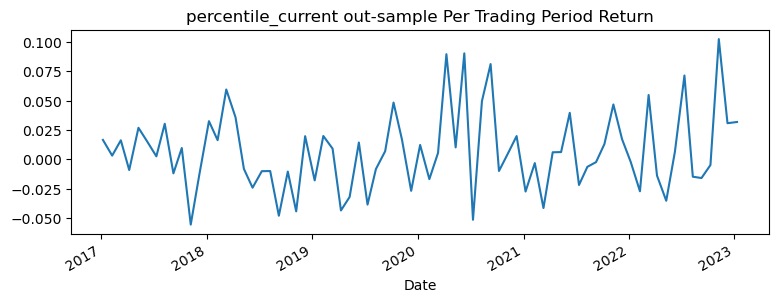

In [1511]:
pipeline.run('percentile_current', params = {
                'pred_period': 'M',
                'holding_period': 21,
                'distribution_period': 63,
                'training_period':2769,
                'periodic': False,
                'cost': 100
            }, currentMode=True)

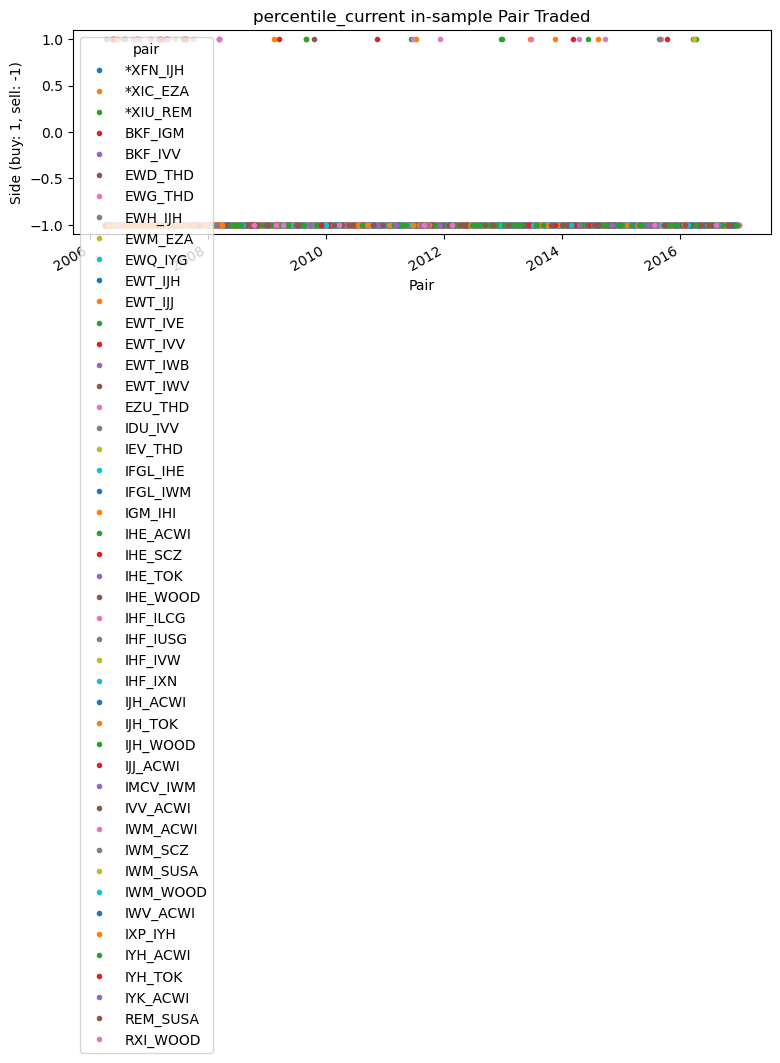

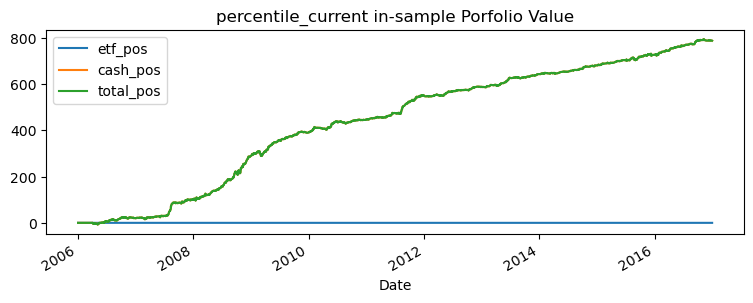

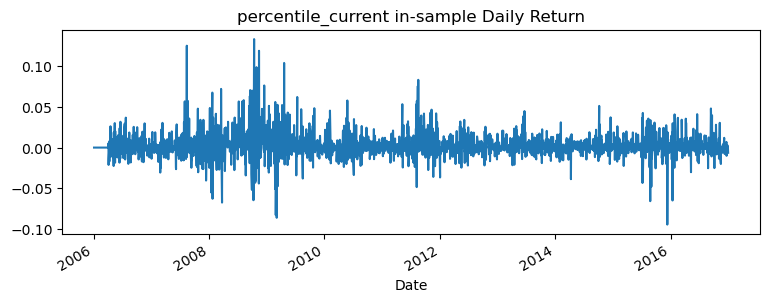

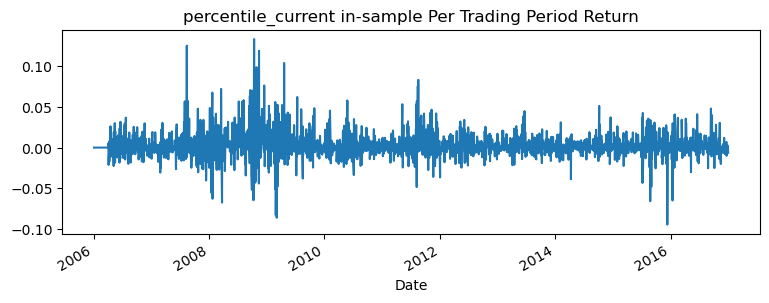

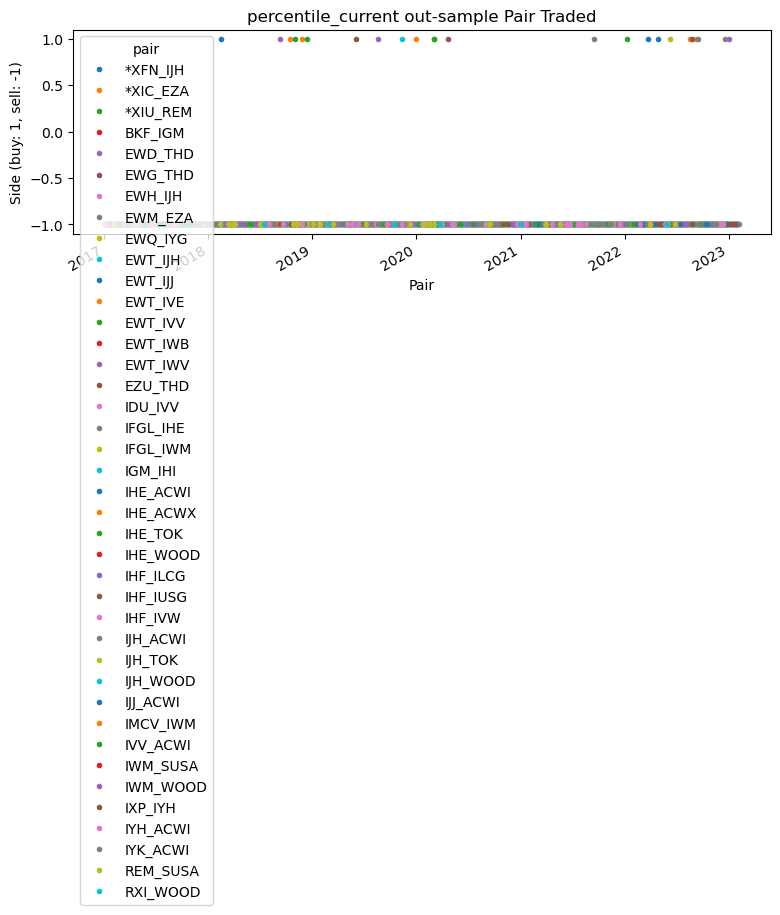

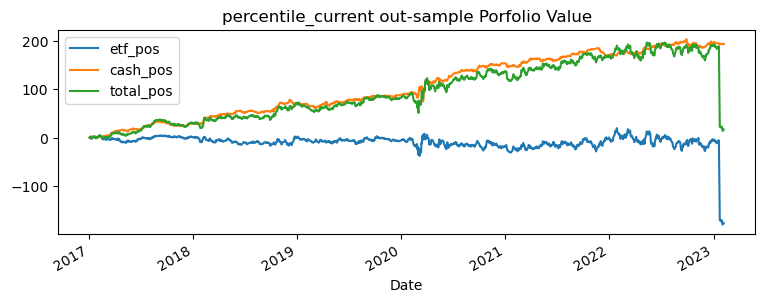

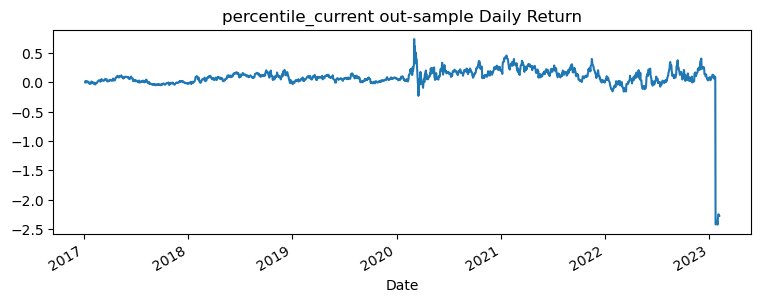

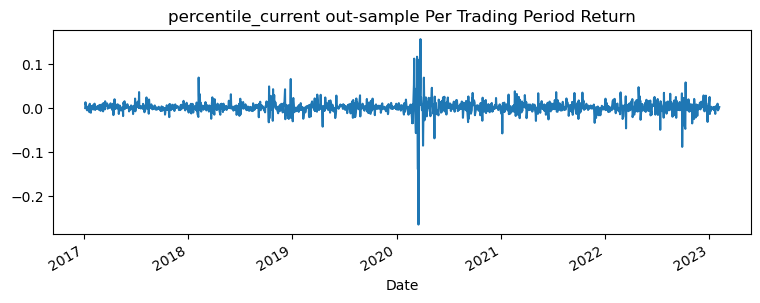

In [1512]:
pipeline.run('percentile_current', params = {
                'pred_period': 'D',
                'holding_period': 1,
                'distribution_period': 10,
                'training_period':63,
                'periodic': True,
                'cost': 100
            }, periodic=True, currentMode=True)

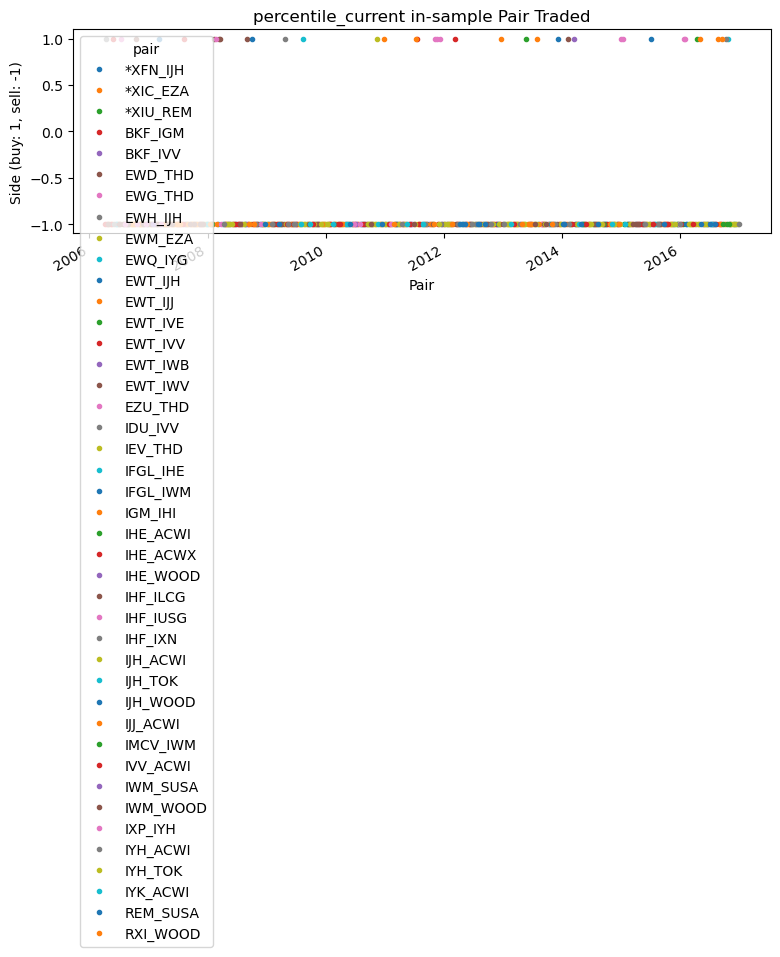

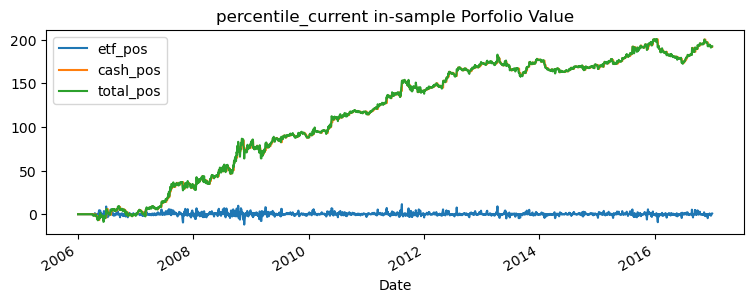

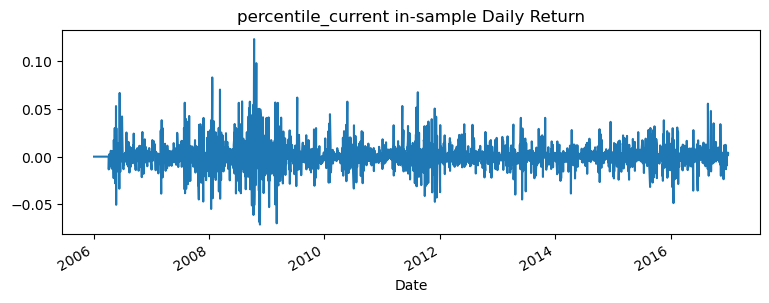

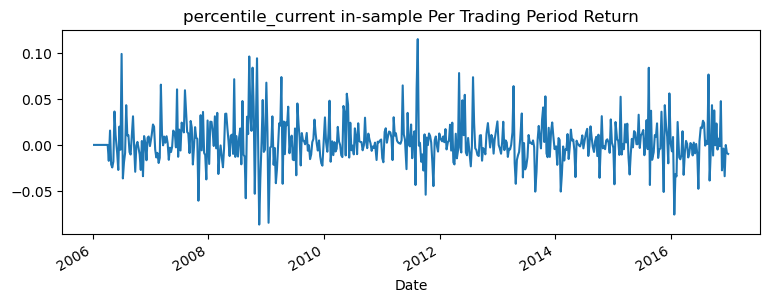

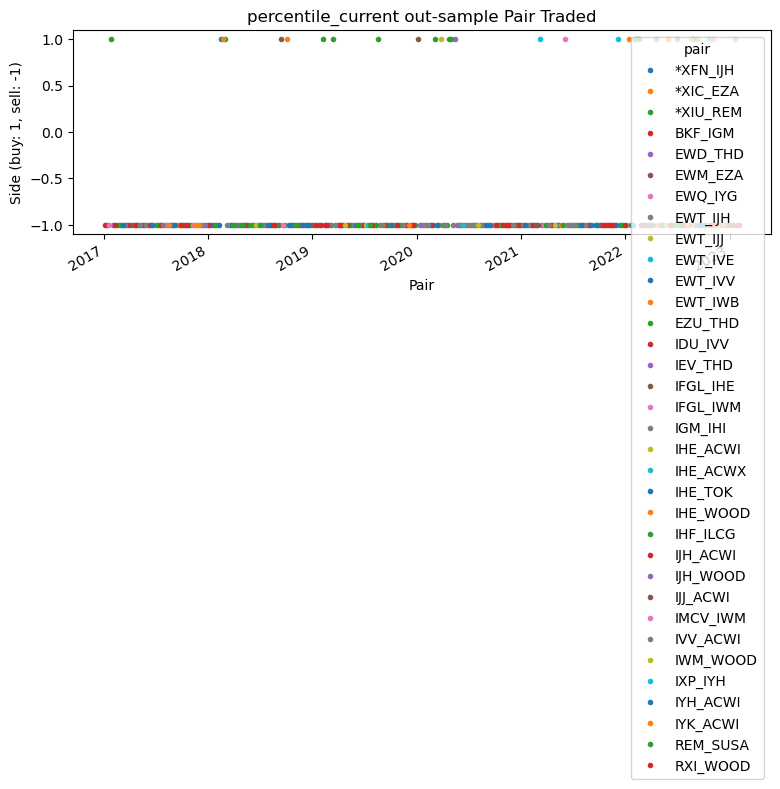

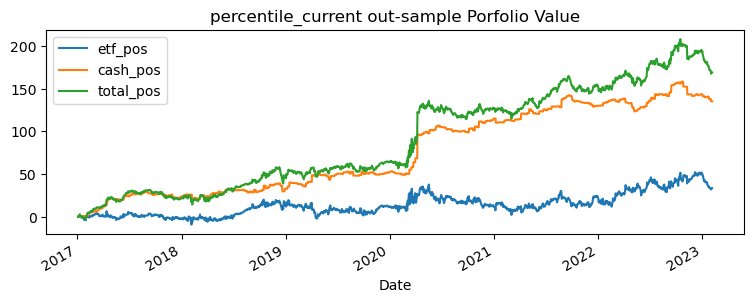

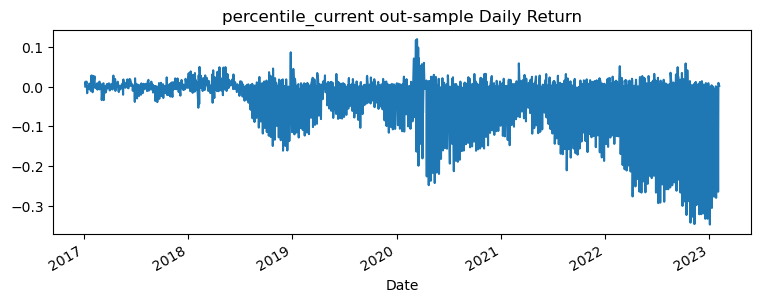

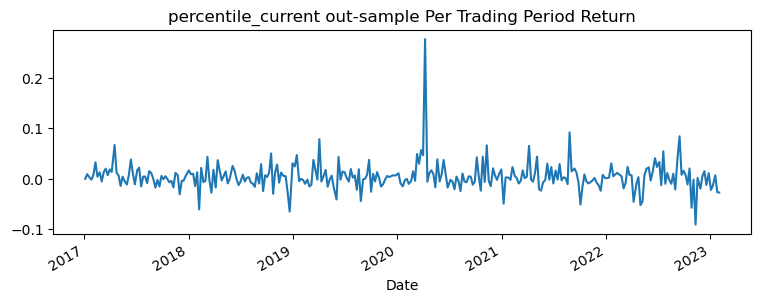

In [1513]:
pipeline.run('percentile_current', params = {
                'pred_period': 'W',
                'holding_period': 5,
                'distribution_period': 21,
                'training_period':63,
                'periodic': True,
                'cost': 100
            }, periodic=True, currentMode=True)

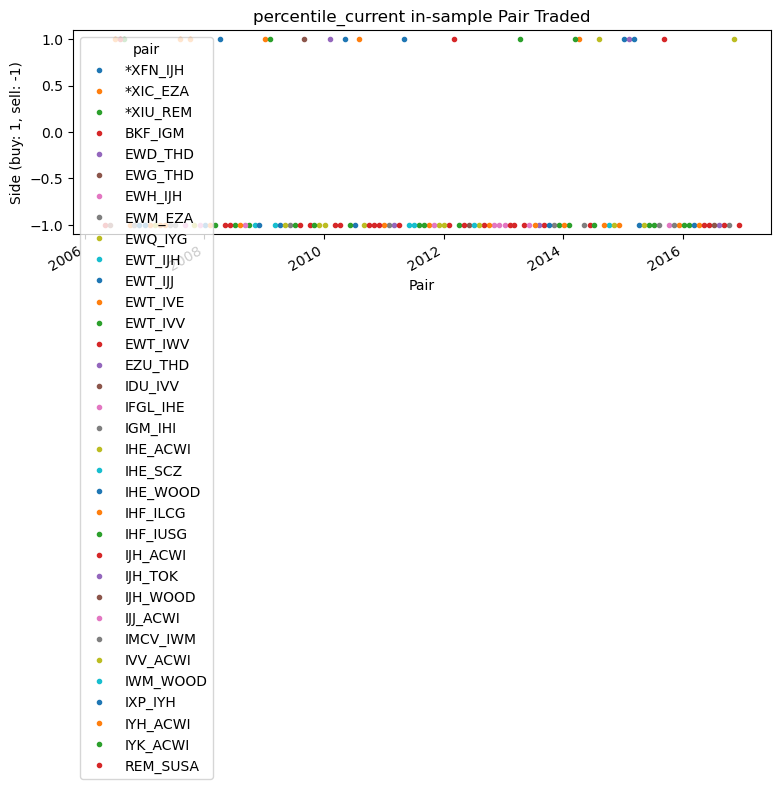

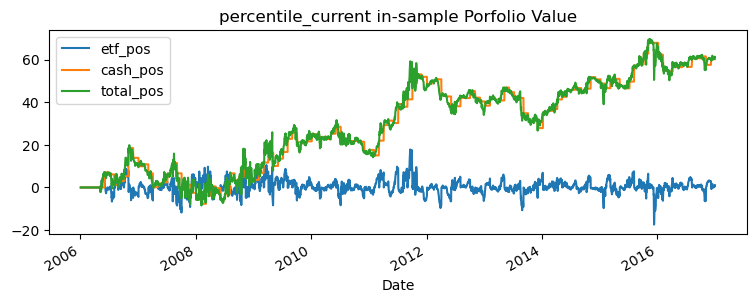

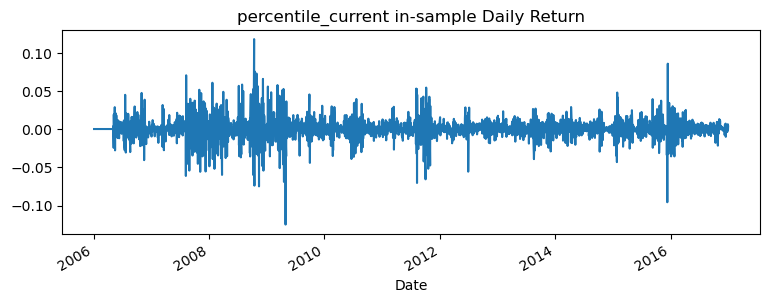

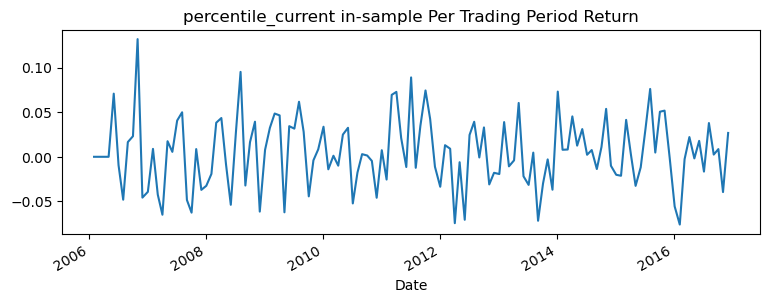

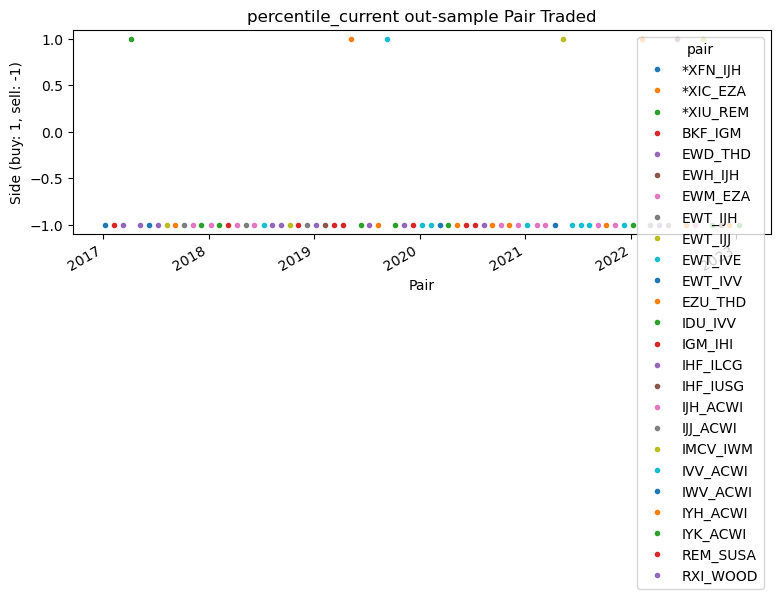

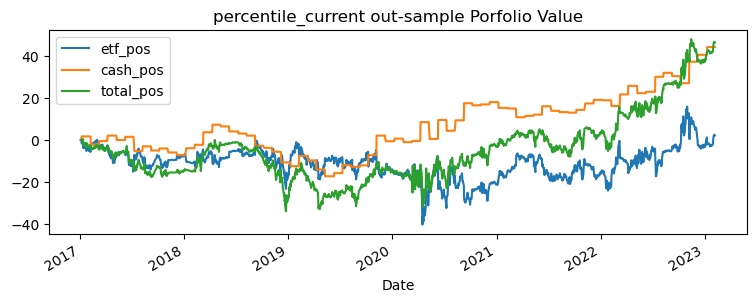

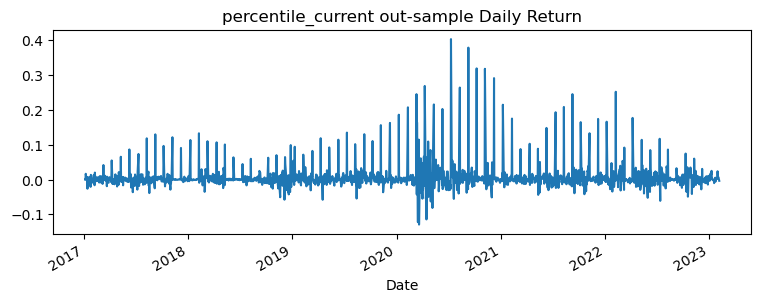

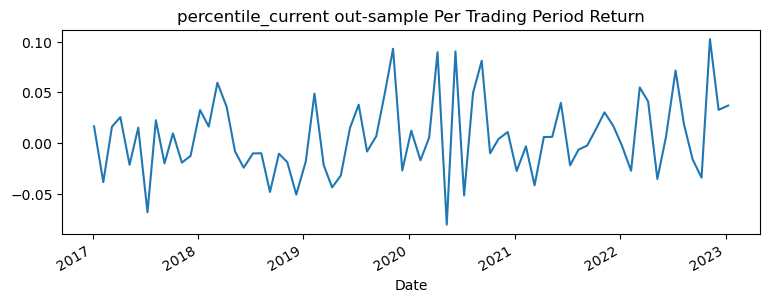

In [1514]:
pipeline.run('percentile_current', params = {
                'pred_period': 'M',
                'holding_period': 21,
                'distribution_period': 63,
                'training_period':84,
                'periodic': True,
                'cost': 100
            }, periodic=True, currentMode=True)

In [1515]:
def ret_sum(reg_df, name):
    nav_df, result_df = performance_for_df(reg_df, rf=0.0)
    print('--------------------------------')
    print(name)
    print(result_df)
    NAV_df_plot(nav_df, nav_df.columns.tolist(), nav_df.columns.tolist(),
                labels=nav_df.columns.tolist(), fig_path=name+".jpg")

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by z

--------------------------------
D in sample daily return
                          linear  linear_periodic     elastic  \
Simple Return          11.548411        18.141518  442.148977   
Annualized Return       0.258867         0.308186    0.741230   
Annualized Volatility   0.292797         0.343829    0.296164   
Sharpe Ratio            0.884118         0.896337    2.502767   
Adjusted Sharpe Ratio   0.508814         0.610866   -4.248290   
Sortino Ratio           1.183725         1.191742    3.583880   
Maximum Drawdown        0.000000         0.000000    0.000000   
Calmar Ratio                 inf              inf         inf   

                       elastic_periodic  percentile_current  \
Simple Return                  6.819063          830.940031   
Annualized Return              0.205824            0.843956   
Annualized Volatility          0.279594            0.251355   
Sharpe Ratio                   0.736152            3.357629   
Adjusted Sharpe Ratio          0.535142  

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown


--------------------------------
D in sample period return
                          linear  linear_periodic     elastic  \
Simple Return          11.548411        18.141518  442.148977   
Annualized Return       0.259182         0.308567    0.742278   
Annualized Volatility   0.292903         0.344263    0.306352   
Sharpe Ratio            0.884872         0.896314    2.422954   
Adjusted Sharpe Ratio   0.508943         0.611995   -1.317057   
Sortino Ratio           1.185162         1.193216    3.739199   
Maximum Drawdown        0.271844         0.000000    0.000000   
Calmar Ratio            0.953422              inf         inf   

                       elastic_periodic  percentile_current  \
Simple Return                  6.819063          830.940031   
Annualized Return              0.206069            0.845180   
Annualized Volatility          0.291849            0.251443   
Sharpe Ratio                   0.706080            3.361315   
Adjusted Sharpe Ratio          0.569098 

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:21: RuntimeWarning: invalid value encountered in double_scalars
  annualized_rtn = (1 + rtn) ** (252 / trading_len) - 1
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:21: RuntimeWarning: invalid value encountered in double_scalars
  annualized_rtn = (1 + rtn) ** (252 / trading_len) - 1
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:21: RuntimeWarning: invalid value encountered in double_scalars
  annualized_rtn = (1 + rtn) ** (252 / trading_len) - 1
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:21: RuntimeWarning: invalid value encountered in double_scalars
  annualized_rtn = (1 + rtn) ** (252 / trading_len) - 1
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluat

--------------------------------
D out sample daily return
                             linear  linear_periodic       elastic  \
Simple Return         -6.023310e+59    -7.830628e+59 -1.447671e+54   
Annualized Return               NaN              NaN           NaN   
Annualized Volatility  3.392947e+00     3.396085e+00  1.814279e+00   
Sharpe Ratio                    NaN              NaN           NaN   
Adjusted Sharpe Ratio           NaN              NaN           NaN   
Sortino Ratio                   NaN              NaN           NaN   
Maximum Drawdown       0.000000e+00     0.000000e+00  0.000000e+00   
Calmar Ratio                    NaN              NaN           NaN   

                       elastic_periodic  percentile_current  \
Simple Return             -4.705786e+53           -1.000000   
Annualized Return                   NaN           -1.000000   
Annualized Volatility      1.767629e+00            1.975894   
Sharpe Ratio                        NaN           -0.50610

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown


--------------------------------
D out sample period return
                         linear  linear_periodic   elastic  elastic_periodic  \
Simple Return         -0.407941        -0.230292       NaN               NaN   
Annualized Return     -0.082554        -0.042114       NaN               NaN   
Annualized Volatility  0.317625         0.347518  0.315336          0.212197   
Sharpe Ratio          -0.259910        -0.121185       NaN               NaN   
Adjusted Sharpe Ratio -0.246014        -0.121741       NaN               NaN   
Sortino Ratio         -0.292494        -0.141680       NaN               NaN   
Maximum Drawdown       0.000000         0.000000  0.000000          0.000000   
Calmar Ratio               -inf             -inf       NaN               NaN   

                       percentile_current  percentile_current_periodic  
Simple Return                    5.632298                     4.620744  
Annualized Return                0.364797                     0.328170  


/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by z

--------------------------------
W in sample daily return
                          linear  linear_periodic     elastic  \
Simple Return          23.535354         9.252835  741.384320   
Annualized Return       0.338079         0.235932    0.824942   
Annualized Volatility   0.249254         0.336854    0.337871   
Sharpe Ratio            1.356363         0.700396    2.441589   
Adjusted Sharpe Ratio   0.720841         0.573928    1.843895   
Sortino Ratio           1.841862         0.895413    3.796825   
Maximum Drawdown        0.000000         0.000000    0.000000   
Calmar Ratio                 inf              inf         inf   

                       elastic_periodic       lstm  percentile_current  \
Simple Return                799.454881  -1.000000            4.319387   
Annualized Return              0.837493  -0.899054            0.164284   
Annualized Volatility          0.332570   0.436693            0.254493   
Sharpe Ratio                   2.518246  -2.058780          

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown


--------------------------------
W in sample period return
                          linear  linear_periodic   elastic  elastic_periodic  \
Simple Return          23.535354         9.252835       NaN               NaN   
Annualized Return       3.287261         1.882745       NaN               NaN   
Annualized Volatility   0.527090         0.636719  0.742325          0.760236   
Sharpe Ratio            6.236616         2.956949       NaN               NaN   
Adjusted Sharpe Ratio -22.186473        -5.008065       NaN               NaN   
Sortino Ratio           9.842885         4.090426       NaN               NaN   
Maximum Drawdown        0.265719         0.000000  0.000000          0.000000   
Calmar Ratio           12.371178              inf       NaN               NaN   

                       lstm  percentile_current  percentile_current_periodic  
Simple Return           NaN                 NaN                          NaN  
Annualized Return       NaN                 NaN      

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:21: RuntimeWarning: invalid value encountered in double_scalars
  annualized_rtn = (1 + rtn) ** (252 / trading_len) - 1
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:21: RuntimeWarning: invalid value encountered in double_scalars
  annualized_rtn = (1 + rtn) ** (252 / trading_len) - 1
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:21:

--------------------------------
W out sample daily return
                             linear  linear_periodic   elastic  \
Simple Return          2.972742e+24     2.677685e+25 -1.000000   
Annualized Return      1.047902e+04     1.503668e+04       NaN   
Annualized Volatility  4.224258e+00     4.167570e+00  1.713643   
Sharpe Ratio           2.480678e+03     3.608021e+03       NaN   
Adjusted Sharpe Ratio -2.097970e+10    -6.564144e+10       NaN   
Sortino Ratio          1.236515e+04     1.834045e+04       NaN   
Maximum Drawdown       0.000000e+00     0.000000e+00  0.000000   
Calmar Ratio                    inf              inf       NaN   

                       elastic_periodic           lstm  percentile_current  \
Simple Return                 -1.000000 -3.539233e+105        5.194043e+19   
Annualized Return                   NaN            NaN        1.731975e+03   
Annualized Volatility          1.717511   1.186107e+03        2.047495e+00   
Sharpe Ratio                      

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by z

--------------------------------
M in sample daily return
                         linear  linear_periodic   elastic  elastic_periodic  \
Simple Return          1.978470         1.096461  9.708868          2.369412   
Annualized Return      0.104427         0.069690  0.240836          0.116893   
Annualized Volatility  0.206890         0.323042  0.301588          0.259427   
Sharpe Ratio           0.504746         0.215729  0.798561          0.450580   
Adjusted Sharpe Ratio  0.456876         0.210174  0.642569          0.441413   
Sortino Ratio          0.682031         0.264239  1.020788          0.626041   
Maximum Drawdown       0.000000         0.000000  0.000000          0.000000   
Calmar Ratio                inf              inf       inf               inf   

                       percentile_current  percentile_current_periodic  
Simple Return                    0.976798                     0.672292  
Annualized Return                0.063983                     0.047908  
An

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown


--------------------------------
M in sample period return
                          linear  linear_periodic   elastic  elastic_periodic  \
Simple Return           1.850819              NaN  0.208030          0.142214   
Annualized Return       6.388879              NaN  0.434479          0.288976   
Annualized Volatility   0.969880              NaN  1.377477          0.398101   
Sharpe Ratio            6.587285              NaN  0.315416          0.725886   
Adjusted Sharpe Ratio -17.565513              NaN  0.345397          0.718203   
Sortino Ratio          11.619604              NaN       NaN               NaN   
Maximum Drawdown        0.282081              0.0  0.000000          0.000000   
Calmar Ratio           22.649107              NaN       inf               inf   

                       percentile_current  percentile_current_periodic  
Simple Return                         NaN                          NaN  
Annualized Return                     NaN                        

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by z

--------------------------------
M out sample daily return
                             linear  linear_periodic   elastic  \
Simple Return          4.595042e+07     1.317555e+33  0.199612   
Annualized Return      1.714401e+01     2.759274e+05  0.030349   
Annualized Volatility  1.027863e+02     9.826650e+01  0.450815   
Sharpe Ratio           1.667927e-01     2.807950e+03  0.067321   
Adjusted Sharpe Ratio  5.298400e-02    -5.005918e+11  0.069016   
Sortino Ratio          1.282180e+01     2.158231e+03  0.093528   
Maximum Drawdown       0.000000e+00     0.000000e+00  0.000000   
Calmar Ratio                    inf              inf       inf   

                       elastic_periodic  percentile_current  \
Simple Return                 -0.433405        1.259751e+04   
Annualized Return             -0.089105        3.716129e+00   
Annualized Volatility          0.827496        6.006844e-01   
Sharpe Ratio                  -0.107680        6.186492e+00   
Adjusted Sharpe Ratio         -

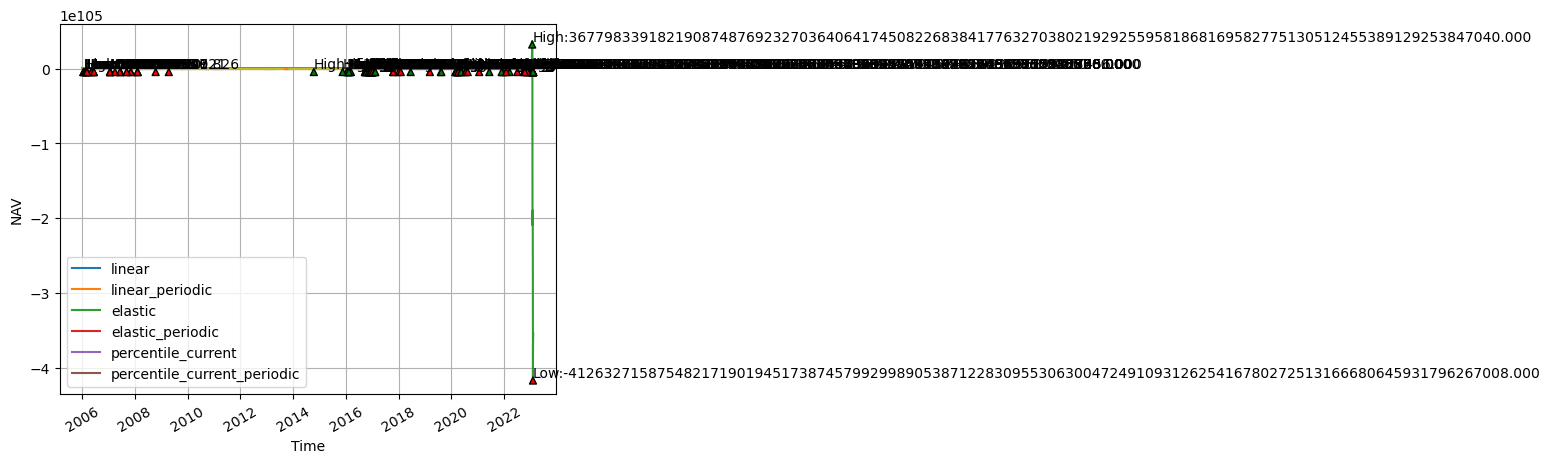

In [1521]:
for p in ['D', 'W', 'M']:
    signal_res = pipeline.signal_result[p]

    in_daily_rets_df = pd.DataFrame()
    in_period_rets_df = pd.DataFrame()
    out_daily_rets_df = pd.DataFrame()
    out_period_rets_df = pd.DataFrame()
    
    for name, df in signal_res.items():
        in_daily_rets_df[name] = df[0][1]
        in_period_rets_df[name] = df[0][2]
        out_daily_rets_df[name] = df[1][1]
        out_period_rets_df[name] = df[1][2]

    ret_sum(in_daily_rets_df, f'{p} in sample daily return')
    ret_sum(in_period_rets_df, f'{p} in sample period return')
    ret_sum(out_daily_rets_df, f'{p} out sample daily return')
    ret_sum(out_period_rets_df, f'{p} out sample period return')
    
